In [1]:
#package imports
import pandas as pd
from datetime import datetime
import numpy as np
from sklearn.linear_model import LinearRegression
import random
from requests import get
from bs4 import BeautifulSoup
from time import sleep
import re
from random import randint #avoid throttling by not sending too many requests one after the other
from warnings import warn
from time import time
from IPython.core.display import clear_output
import numpy as np
from bs4 import BeautifulSoup
from requests import get
import pandas as pd
from sklearn.model_selection import train_test_split
import ast
import json
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
#start to look at the distributions
from matplotlib import figure
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from scipy.stats import pointbiserialr
from sklearn.preprocessing import StandardScaler
import geopy.distance
%matplotlib inline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster


C:\Users\Daniel\AppData\Local\Temp\ipykernel_17656\2333273987.py:14: DeprecationWarning: Importing clear_output from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import clear_output


## Data Imports

### school data from 

In [2]:
# dataset of BC schools
schools = pd.read_csv('bc_schools.csv')

In [3]:
# dataset containing scrapes of craigslist apartments
# 4 scrapes were done:
# 1) No query, 2) Query = 'Sauna', 3) Query = 'Pool', 4) Query = 'Steam Room'

van = pd.read_csv('second_level_data_scrape.csv')

In [4]:
len(set(van['links']))

8663

In [5]:
schools.columns

Index(['Index', 'Source_ID', 'Facility_Name', 'Facility_Type',
       'Authority_Name', 'ISCED010', 'ISCED020', 'ISCED1', 'ISCED2', 'ISCED3',
       'ISCED4Plus', 'OLMS_Status', 'Full_Addr', 'Unit', 'Street_No',
       'Street_Name', 'City', 'Prov_Terr', 'Postal_Code', 'PRUID', 'CSDNAME',
       'CSDUID', 'Longitude', 'Latitude', 'Geo_Source', 'Provider', 'CMANAME',
       'CMAUID'],
      dtype='object')

In [6]:
van[['min_dist', 'min_dist_school_name', 'min_dist_school_type']] = np.nan

In [7]:
schools = schools.dropna(subset=['Longitude', 'Latitude'])
schools = schools.reset_index(drop=True)
for i,row in van.dropna(subset=['longitude', 'latitude']).iterrows(): # A
    a = row.latitude, row.longitude
    distances = []
    for j,row2 in schools.iterrows(): # B
        b = row2.Latitude, row2.Longitude
        distances.append(geopy.distance.geodesic(a, b).km)

    min_distance = min(distances)
    min_index = distances.index(min_distance)
    
    van.loc[i, 'min_dist'] = min_distance
    van.loc[i, 'min_dist_school_name'] = schools.loc[min_index,'Facility_Name']
    van.loc[i, 'min_dist_school_type'] = schools.loc[min_index, 'Facility_Type']
    print(f"{van.loc[i, 'links']} is closest to {schools.loc[min_index, 'Facility_Name']} with a distance of {min_distance} km")

https://vancouver.craigslist.org/rds/apa/d/white-rock-white-rock-condo-across-from/7581092960.html is closest to St John Paul II Academy with a distance of 0.928307459481349 km
https://vancouver.craigslist.org/nvn/apa/d/north-vancouver-north-shore-living-best/7585253457.html is closest to Lynnmour Elementary School with a distance of 0.2002048989702344 km
https://vancouver.craigslist.org/nvn/apa/d/north-vancouver-obsoldcom-stunning/7582125288.html is closest to St Edmund's with a distance of 0.9094655875826001 km
https://vancouver.craigslist.org/van/apa/d/vancouver-vancouver-west-townhouse/7579735887.html is closest to Pierre Elliott Trudeau Elementary with a distance of 0.19590419628011382 km
https://vancouver.craigslist.org/rds/apa/d/delta-apartment-for-rent/7584251089.html is closest to Holly Elementary with a distance of 1.4060159307236677 km
https://vancouver.craigslist.org/van/apa/d/vancouver-underground-parking-quartz/7572673342.html is closest to Lord Roberts Annex with a dista

https://vancouver.craigslist.org/rds/apa/d/surrey-outer-northwest-bed-and-den-bath/7581373133.html is closest to Prince Charles Elementary with a distance of 0.5864956217594571 km
https://vancouver.craigslist.org/van/apa/d/vancouver-beautiful-and-bright-br-condo/7583379049.html is closest to Pierre Elliott Trudeau Elementary with a distance of 0.19590419628011382 km
https://vancouver.craigslist.org/bnc/apa/d/new-westminster-call-me-home-near/7585037035.html is closest to École Qayqayt Elementary with a distance of 0.20273020698939698 km
https://vancouver.craigslist.org/bnc/apa/d/burnaby-brand-new-bedroom-apartment/7573937579.html is closest to École Marlborough Elementary with a distance of 0.2976011339301038 km
https://vancouver.craigslist.org/rch/apa/d/richmond-deluxe-bedroom-at-prado/7583337247.html is closest to Maple Leaf School - KPU with a distance of 0.4474319569580884 km
https://vancouver.craigslist.org/van/apa/d/vancouver-one-bedroom-unit-available-in/7585684813.html is close

https://vancouver.craigslist.org/rds/apa/d/burnaby-furnished-available-now-close/7578029039.html is closest to John Knox Christian - Elementary Campus with a distance of 0.6841408990527761 km
https://vancouver.craigslist.org/nvn/apa/d/north-vancouver-southwest-bed-bathroom/7581721908.html is closest to Norgate Community Elementary with a distance of 0.3797340524913793 km
https://vancouver.craigslist.org/pml/apa/d/coquitlam-beds-2baths-townhouse-in/7585072789.html is closest to Our Lady of Fatima with a distance of 0.26539292093748257 km
https://vancouver.craigslist.org/van/apa/d/vancouver-ultra-customized-morden/7584228501.html is closest to Queen Mary Elementary with a distance of 0.26466841130948443 km
https://vancouver.craigslist.org/rds/apa/d/delta-bedroom-bath-penthouse-condo-view/7580449951.html is closest to Kirkbride Elementary with a distance of 0.3392589743119248 km
https://vancouver.craigslist.org/van/apa/d/vancouver-furnished-bed-bath-loft-in/7582599470.html is closest to T

https://vancouver.craigslist.org/nvn/apa/d/north-vancouver-northwest-central-north/7581685685.html is closest to Carisbrooke Elementary with a distance of 1.0601324669014327 km
https://vancouver.craigslist.org/rds/apa/d/surrey-townhouse-for-rent-april-pets/7585016082.html is closest to St Matthew's Elementary with a distance of 0.5074404938536491 km
https://vancouver.craigslist.org/van/apa/d/vancouver-near-ubc-bed-bath-for-rent/7581529585.html is closest to Quilchena Elementary with a distance of 0.2756296510737759 km
https://vancouver.craigslist.org/van/apa/d/vancouver-available-april-1st-pet/7580960230.html is closest to King George Secondary with a distance of 1.0946046689544626 km
https://vancouver.craigslist.org/nvn/apa/d/west-vancouver-offer-large-and-cozy/7585346101.html is closest to Ridgeview Elementary with a distance of 0.562170729641428 km
https://vancouver.craigslist.org/van/apa/d/vancouver-comfortable-and-convenient/7583635111.html is closest to Whytecliff Agile Learning 

https://vancouver.craigslist.org/rds/apa/d/surrey-nicely-updated-rancher-in-south/7577220190.html is closest to North Ridge Elementary with a distance of 0.5986430064217335 km
https://vancouver.craigslist.org/rds/apa/d/surrey-newly-renod-bed-bath-and-den/7578807547.html is closest to Jessie Lee Elementary with a distance of 0.16821752116039915 km
https://vancouver.craigslist.org/rds/apa/d/surrey-brand-new-renovated-suite/7585661955.html is closest to Holly Elementary with a distance of 0.660391638269898 km
https://vancouver.craigslist.org/rds/apa/d/langley-large-bedroom-cat-ok/7577529971.html is closest to Gobind Sarvar School with a distance of 0.6233157413710526 km
https://vancouver.craigslist.org/bnc/apa/d/new-westminster-bedroom-suite-in-suite/7575403956.html is closest to The Global School with a distance of 0.6470266193285725 km
https://vancouver.craigslist.org/van/apa/d/vancouver-bdrm-fully-furnished-unit/7578962707.html is closest to Al-Hidayah School with a distance of 0.19538

https://vancouver.craigslist.org/rds/apa/d/langley-townhouse-3bed-25bath/7569047487.html is closest to Elsie Roy Elementary with a distance of 0.750050533705216 km
https://vancouver.craigslist.org/bnc/apa/d/burnaby-new-house-fully-fenced-backyard/7586000579.html is closest to Peter Ewart Middle School with a distance of 0.8947665654431273 km
https://vancouver.craigslist.org/bnc/apa/d/new-westminster-bright-studio-in-suite/7583514077.html is closest to Brantford Elementary with a distance of 0.27198389840891773 km
https://vancouver.craigslist.org/van/apa/d/vancouver-main-cambie-house-upper-for/7584225527.html is closest to Sir Wilfred Grenfell Community with a distance of 0.4823578274647199 km
https://vancouver.craigslist.org/van/apa/d/vancouver-brand-new-luxurious-two/7575684568.html is closest to General Wolfe Elementary with a distance of 0.3656269498304903 km
https://vancouver.craigslist.org/rds/apa/d/chilliwack-furnished-apartment-bedrooms/7577188811.html is closest to Pattison Hig

https://vancouver.craigslist.org/van/apa/d/vancouver-spacious-bedrooms-house-in/7581851852.html is closest to Mountain Meadows Elementary with a distance of 0.8654049907645396 km
https://vancouver.craigslist.org/van/apa/d/vancouver-rare-luxurious-furnished-unit/7575592525.html is closest to Elsie Roy Elementary with a distance of 0.4796376337890539 km
https://vancouver.craigslist.org/rch/apa/d/richmond-richmond-center-highly/7585064810.html is closest to Kerrisdale Elementary with a distance of 0.630522458877883 km
https://vancouver.craigslist.org/van/apa/d/vancouver-available-march-1st-brand-new/7584707960.html is closest to King George Secondary with a distance of 1.0946046689544626 km
https://vancouver.craigslist.org/rds/apa/d/surrey-bedroom-bath-at-park-boulevard/7582451478.html is closest to Samuel Brighouse Elementary with a distance of 0.5962949976838616 km
https://vancouver.craigslist.org/rds/apa/d/surrey-inner-northwest-like-new-bedroom/7585236050.html is closest to A H P Matt

https://vancouver.craigslist.org/pml/apa/d/port-moody-private-balconies-soaker-tub/7581382348.html is closest to Honour Secondary School with a distance of 0.223075964234047 km
https://vancouver.craigslist.org/van/apa/d/vancouver-best-location-quiet-family/7568309254.html is closest to St Thomas More Collegiate with a distance of 0.3316255776932188 km
https://vancouver.craigslist.org/van/apa/d/vancouver-fully-furnished-large-bedroom/7585749547.html is closest to Lord Roberts Annex with a distance of 0.39975564584578516 km
https://vancouver.craigslist.org/bnc/apa/d/burnaby-bedroom-bathroom-kitchen-living/7575410422.html is closest to Anmore Elementary with a distance of 1.3124960156463827 km
https://vancouver.craigslist.org/van/apa/d/vancouver-main-floor-bedroom-plus-low/7574647511.html is closest to Westside Montessori School with a distance of 0.348679589900968 km
https://vancouver.craigslist.org/bnc/apa/d/burnaby-brand-new-sfu-bedroom-for-rent/7581088760.html is closest to Pattison H

https://vancouver.craigslist.org/van/apa/d/vancouver-pet-friendly-available/7583335980.html is closest to Woodward Hill Elementary with a distance of 0.8226156115916807 km
https://vancouver.craigslist.org/rch/apa/d/richmond-richmond-studio-suite-on-2nd/7585754106.html is closest to Honour Secondary School with a distance of 0.41519535532315016 km
https://vancouver.craigslist.org/van/apa/d/vancouver-top-floor-concrete-building/7582270909.html is closest to Alouette Elementary with a distance of 0.38712788523551467 km
https://vancouver.craigslist.org/van/apa/d/vancouver-bedroom-basement/7580496503.html is closest to École Marlborough Elementary with a distance of 0.5685826849562472 km
https://vancouver.craigslist.org/van/apa/d/vancouver-bedroomden-furnished/7578845070.html is closest to Pattison High School with a distance of 0.4961865806403434 km
https://vancouver.craigslist.org/rds/apa/d/surrey-furnished-walkout-studio-for-rent/7574150497.html is closest to Vancouver Talmud Torah Eleme

https://vancouver.craigslist.org/van/apa/d/d2-heart-of-downtown-upscale-fully/7579876639.html is closest to Norgate Community Elementary with a distance of 0.3797340524913793 km
https://vancouver.craigslist.org/bnc/apa/d/burnaby-amazing-apartmentamazing-price/7581907447.html is closest to General Gordon Elementary with a distance of 0.5706678084669183 km
https://vancouver.craigslist.org/van/apa/d/vancouver-large-studio-next-to-seawall/7584632119.html is closest to Lord Kitchener Elementary with a distance of 0.28463066304747586 km
https://vancouver.craigslist.org/van/apa/d/vancouver-bedroomden-furnished/7582418795.html is closest to Maple Lane Elementary with a distance of 0.2258636349779115 km
https://vancouver.craigslist.org/van/apa/d/vancouver-bike-storage-outdoor-patio/7575702729.html is closest to Richard McBride Elementary with a distance of 0.723144213284787 km
https://vancouver.craigslist.org/nvn/apa/d/north-vancouver-orcaref-ebright-and/7585021732.html is closest to Pattison H

https://vancouver.craigslist.org/rds/apa/d/surrey-bedrooms-basement-in-newton-sry/7578502149.html is closest to École Marlborough Elementary with a distance of 0.2976011339301038 km
https://vancouver.craigslist.org/van/apa/d/vancouver-beds-baths-ubc-wesbrook-unit/7568854236.html is closest to King George Secondary with a distance of 1.0946046689544626 km
https://vancouver.craigslist.org/van/apa/d/vancouver-luxury-unfurnished-bedroom-25/7578242473.html is closest to Vancouver Hebrew Academy with a distance of 0.13210880690822127 km
https://vancouver.craigslist.org/van/apa/d/north-vancouver-stunning-17th-floor/7579854362.html is closest to Bayridge Elementary with a distance of 0.45843144806528363 km
https://vancouver.craigslist.org/rds/apa/d/surrey-upper-west-two-bedroom-basement/7583288172.html is closest to The Westside School with a distance of 0.11790630056840837 km
https://vancouver.craigslist.org/van/apa/d/langley-city-spacious-bed-den-or-bed/7573637553.html is closest to Anne-Heb

https://vancouver.craigslist.org/van/apa/d/vancouver-on-pretty-streetscape/7577477645.html is closest to Eaton Arrowsmith School White Rock with a distance of 0.5339333598558934 km
https://vancouver.craigslist.org/bnc/apa/d/burnaby-brentwood-newly-renovated-bed/7584009058.html is closest to St John's Academy with a distance of 0.5653366814282265 km
https://vancouver.craigslist.org/rds/apa/d/surrey-beautiful-1bedroom-and-bath-bsmt/7582190450.html is closest to Anmore Elementary with a distance of 1.3124960156463827 km
https://vancouver.craigslist.org/pml/apa/d/coquitlam-bedroom-suite-in-new-house/7584387950.html is closest to Brockton Preparatory School with a distance of 0.2616183788127354 km
https://vancouver.craigslist.org/pml/apa/d/coquitlam-top-floor-clean-home-near/7586023062.html is closest to Brooksbank Elementary with a distance of 0.2384378478895701 km
https://vancouver.craigslist.org/van/apa/d/vancouver-beautiful-fully-furnished/7567621812.html is closest to Daniel Woodward E

https://vancouver.craigslist.org/van/apa/d/vancouver-luxury-bedroom-condo-for-rent/7575277878.html is closest to Honour Secondary School with a distance of 0.41519535532315016 km
https://vancouver.craigslist.org/van/apa/d/vancouver-new-building-available-april/7584719871.html is closest to King David High School with a distance of 0.3228003406332006 km
https://vancouver.craigslist.org/van/apa/d/vancouver-downtown-vancouver-studio/7575678067.html is closest to Crescent Park Elementary with a distance of 0.9854002692283191 km
https://vancouver.craigslist.org/van/apa/d/vancouver-fully-furnished-bedroom-newly/7570127947.html is closest to Eaton Arrowsmith School White Rock with a distance of 0.5339333598558934 km
https://vancouver.craigslist.org/van/apa/d/vancouver-outdoor-patio-and-bbq-area/7575668550.html is closest to Douglas Park Community with a distance of 0.15657877269056092 km
https://vancouver.craigslist.org/pml/apa/d/coquitlam-north-bedroom-for-rent/7585295459.html is closest to 

https://vancouver.craigslist.org/rds/apa/d/white-rock-elevator-in-one-building/7578660850.html is closest to Lord Roberts Annex with a distance of 0.04782534660185969 km
https://vancouver.craigslist.org/rds/apa/d/surrey-brand-new-luxury-bed-plus-den-25/7575381127.html is closest to Maywood Community Elementary with a distance of 0.6116034242559585 km
https://vancouver.craigslist.org/van/apa/d/kelowna-north-brand-new-furnished/7583361243.html is closest to L'École Bilingue Elementary with a distance of 0.3459359609129701 km
https://vancouver.craigslist.org/nvn/apa/d/north-vancouver-orcaref-fully-furnished/7584376029.html is closest to Buckingham Elementary with a distance of 0.24365886701164666 km
https://vancouver.craigslist.org/van/apa/d/vancouver-tv-tower-2br-2bath-den-flex/7584944876.html is closest to Lord Roberts Annex with a distance of 0.29036336513485483 km
https://vancouver.craigslist.org/van/apa/d/vancouver-2blk-fr-commercial-skytrain/7578839998.html is closest to Maple Ridge

https://vancouver.craigslist.org/pml/apa/d/port-coquitlam-legal-suite/7584732612.html is closest to Kitchener Elementary with a distance of 0.9371465392566254 km
https://vancouver.craigslist.org/van/apa/d/vancouver-penthouse-downtown-vancouver/7584311853.html is closest to The Westside School with a distance of 0.11790630056840837 km
https://vancouver.craigslist.org/van/apa/d/sechelt-house-for-rent-long-term/7576248658.html is closest to The Westside School with a distance of 0.11790630056840837 km
https://vancouver.craigslist.org/rds/apa/d/langley-township-northwest-luxurious/7570962434.html is closest to G.A.D. Elementary School with a distance of 0.6097417271206801 km
https://vancouver.craigslist.org/van/apa/d/vancouver-gorgeous-furnished-studio/7562160350.html is closest to Eaton Arrowsmith School with a distance of 1.0030536412109246 km
https://vancouver.craigslist.org/rds/apa/d/delta-3br-rancher-for-rent-in-pebble/7580128696.html is closest to English Bluff Elementary with a dist

https://vancouver.craigslist.org/van/apa/d/vancouver-beautiful-bed-bath-condo-for/7583324614.html is closest to King David High School with a distance of 0.3017053762607725 km
https://vancouver.craigslist.org/van/apa/d/vancouver-marinegateway-32f-super/7573584572.html is closest to Champlain Heights Annex with a distance of 1.0883544545082522 km
https://vancouver.craigslist.org/bnc/apa/d/burnaby-c-pet-friendly-apartment-unit/7584976119.html is closest to Lynnmour Elementary School with a distance of 0.7093103596493308 km
https://vancouver.craigslist.org/pml/apa/d/port-moody-playground-microwave-quartz/7566516373.html is closest to Lord Roberts Annex with a distance of 0.3609826503600473 km
https://vancouver.craigslist.org/van/apa/d/vancouver-premium-luxury-suite-with-all/7584524800.html is closest to The Westside School with a distance of 0.35541403358423285 km
https://vancouver.craigslist.org/van/apa/d/vancouver-pet-friendly-bed-bath-with/7561309738.html is closest to Elsie Roy Elemen

KeyboardInterrupt: 

In [ ]:
schools

In [ ]:
schools_dist_calc

In [8]:
van.to_csv('van_with_schools.csv', index = False)

In [7]:
van = pd.read_csv('van_with_schools.csv')

## Final Data Cleaning

In [8]:
# Fill NaN values in sauna, pool, steam columns with False.
#NaN values in one of these columns indicates the listing didnt mention that key word. 
van[['sauna', 'pool', 'steam']] = van[['sauna', 'pool', 'steam']].fillna(False)

In [9]:
#format sqfts and price column to make them a number
van['sqfts'] = pd.to_numeric(van['sqfts'].str.rstrip('ft2'))
van['price'] = van['price'].str.replace(',', '').str.replace('$', '').astype(float)

C:\Users\Daniel\AppData\Local\Temp\ipykernel_17656\379010520.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  van['price'] = van['price'].str.replace(',', '').str.replace('$', '').astype(float)


In [10]:
van.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8663 entries, 0 to 8662
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   price                 7961 non-null   float64
 1   bedrooms              7927 non-null   float64
 2   sqfts                 6755 non-null   float64
 3   longitude             7920 non-null   float64
 4   name                  7927 non-null   object 
 5   latitude              7920 non-null   float64
 6   bathrooms_level_two   7921 non-null   float64
 7   streetAddress         4903 non-null   object 
 8   country               7917 non-null   object 
 9   locality              7917 non-null   object 
 10  postal                7917 non-null   object 
 11  region                7917 non-null   object 
 12  housing_type          7917 non-null   object 
 13  links                 8663 non-null   object 
 14  sauna                 8663 non-null   bool   
 15  pool                 

## Distributions

In [11]:
sauna = van[van['sauna'] == True]
no_sauna = van[van['sauna'] == False]

### Price Distribution with Sauna

Text(0.5, 1.0, 'Distribution of Monthly Rents with Sauna')

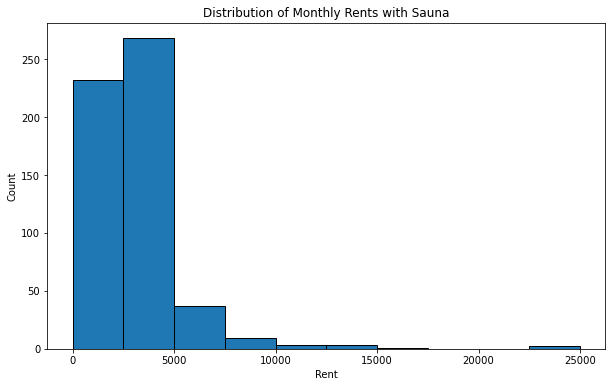

In [12]:
plt.figure(figsize=(10, 6))
plt.hist(sauna['price'], edgecolor='black')
plt.xlabel("Rent")
plt.ylabel('Count')
plt.title("Distribution of Monthly Rents with Sauna")

### Rent Distribution without Sauna

Text(0.5, 1.0, 'Distribution of Prices without Sauna')

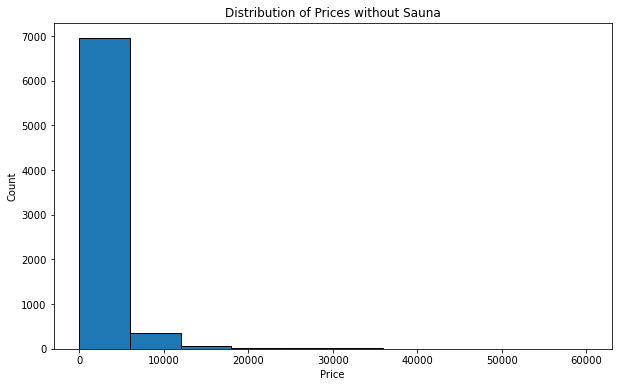

In [13]:
plt.figure(figsize=(10, 6))
plt.hist(no_sauna['price'], edgecolor='black')
plt.xlabel("Price")
plt.ylabel('Count')
plt.title("Distribution of Prices without Sauna")

#### Price vs Square Footage with Sauna

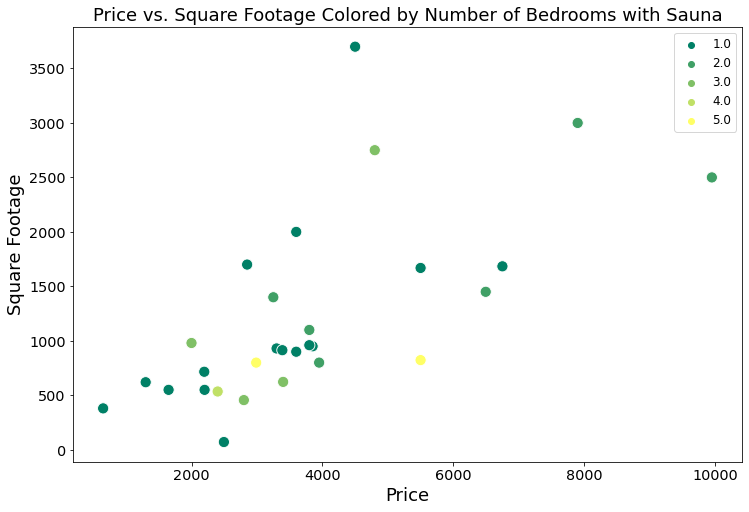

In [14]:
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

plt.figure(figsize=(12, 8))
sns.scatterplot(x='price', y='sqfts', hue='bedrooms', palette='summer', x_jitter=True, y_jitter=True, s=125, data=sauna.dropna())
plt.legend(fontsize=12)
plt.xlabel("Price", fontsize=18)
plt.ylabel("Square Footage", fontsize=18);
plt.title("Price vs. Square Footage Colored by Number of Bedrooms with Sauna", fontsize=18);

#### Price vs Square Footage without Sauna

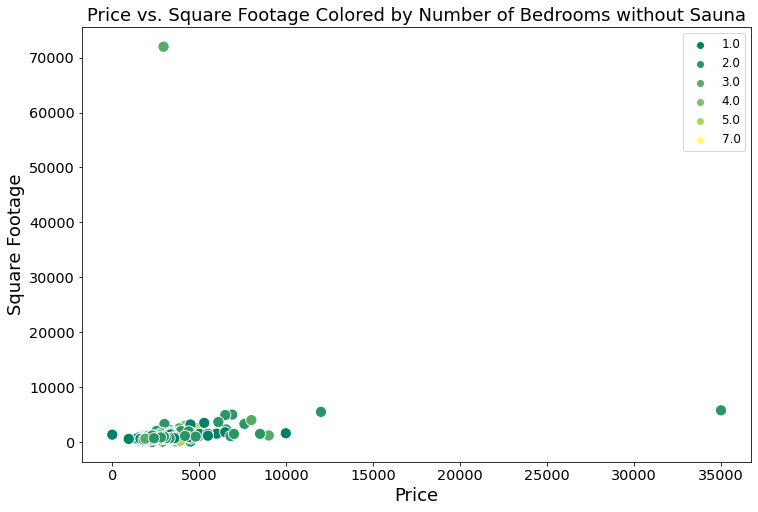

In [15]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

plt.figure(figsize=(12, 8))
sns.scatterplot(x='price', y='sqfts', hue='bedrooms', palette='summer', x_jitter=True, y_jitter=True, s=125, data=no_sauna.dropna())
plt.legend(fontsize=12)
plt.xlabel("Price", fontsize=18)
plt.ylabel("Square Footage", fontsize=18);
plt.title("Price vs. Square Footage Colored by Number of Bedrooms without Sauna", fontsize=18);

#### Price vs Square Footage Regressions with Sauna

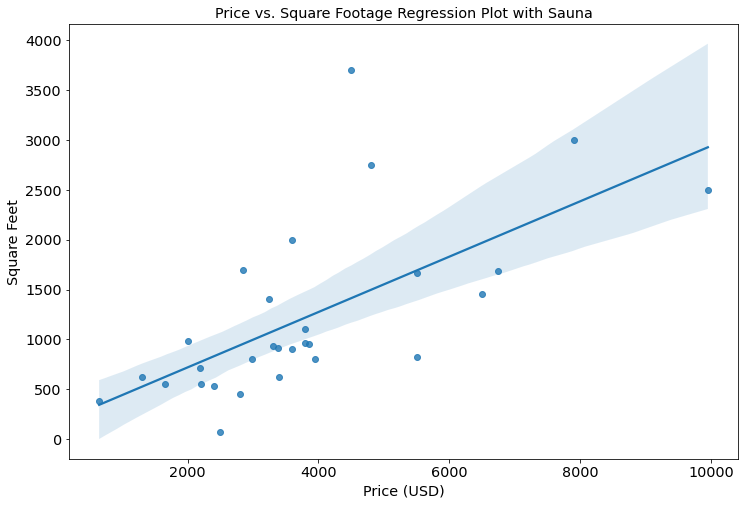

In [16]:
plt.figure(figsize=(12, 8))
sns.regplot(x='price', y='sqfts', data=sauna.dropna());
plt.title('Price vs. Square Footage Regression Plot with Sauna');
plt.xlabel("Price (USD)");
plt.ylabel("Square Feet");

#### Price vs Square Footage Regressions with Sauna

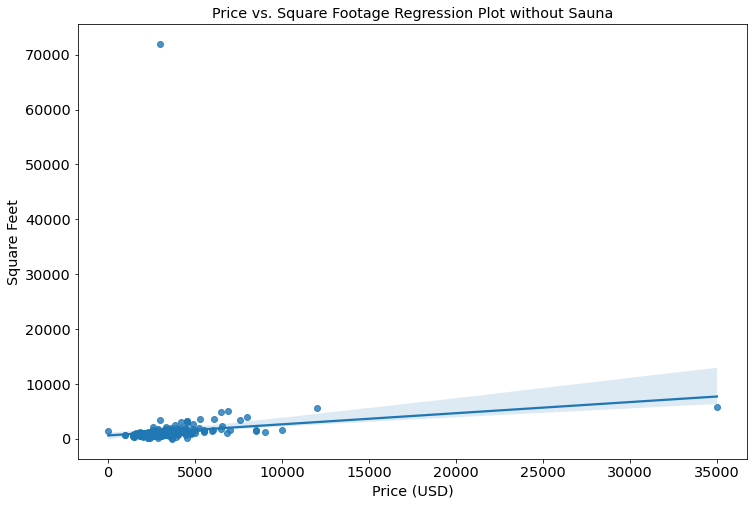

In [17]:
plt.figure(figsize=(12, 8))
sns.regplot(x='price', y='sqfts', data=no_sauna.dropna());
plt.title('Price vs. Square Footage Regression Plot without Sauna');
plt.xlabel("Price (USD)");
plt.ylabel("Square Feet");

#### Mean Price by Neighborhood with Sauna

In [18]:
sauna.groupby('locality').mean()

,price,bedrooms,sqfts,longitude,latitude,bathrooms_level_two,sauna,pool,steam,min_dist
locality,,,,,,,,,,
Burnaby,3331.729730,2.125000,1029.474576,-123.008134,49.222561,1.684211,1.0,0.518987,0.151899,1.160076
Coquitlam,2825.666667,1.538462,772.800000,-122.990345,49.236956,2.000000,1.0,0.500000,0.214286,NaN
Coquitlam North,2307.000000,1.166667,1017.600000,-122.991289,49.265301,1.000000,1.0,0.714286,0.714286,NaN
Delta,4500.000000,1.500000,2360.000000,-123.163580,49.272031,2.000000,1.0,0.500000,0.000000,NaN
Langley City,3000.000000,2.000000,NaN,-123.038000,49.217500,2.000000,1.0,1.000000,0.000000,0.575916
Maple Ridge,1900.000000,1.000000,500.000000,-123.158600,49.229100,2.000000,1.0,1.000000,1.000000,NaN
New Westminster,2350.000000,2.000000,NaN,-122.972873,49.234600,2.000000,1.0,0.000000,0.000000,NaN
New Westminster Northeast,2377.500000,3.500000,608.500000,-123.065672,49.242607,2.000000,1.0,0.000000,1.000000,NaN
North Vancouver,3519.968750,1.685714,1121.178571,-123.004112,49.233291,1.774194,1.0,0.583333,0.388889,0.502280


In [19]:
sauna.groupby('locality').mean()['price'].sort_values()

locality
Surrey Lower West               1700.000000
West Vancouver West             1750.000000
Maple Ridge                     1900.000000
Port Coquitlam                  2200.000000
Surrey Inner Northwest          2215.833333
Coquitlam North                 2307.000000
New Westminster                 2350.000000
New Westminster Northeast       2377.500000
Port Coquitlam Central          2395.000000
West Vancouver South            2700.000000
Coquitlam                       2825.666667
Langley City                    3000.000000
North Vancouver Southwest       3021.071429
West Vancouver                  3043.500000
Vancouver                       3224.343066
Surrey                          3277.857143
Burnaby                         3331.729730
North Vancouver                 3519.968750
Richmond South                  3600.000000
Port Moody                      3642.222222
White Rock                      3649.500000
Richmond                        3763.000000
Delta                  

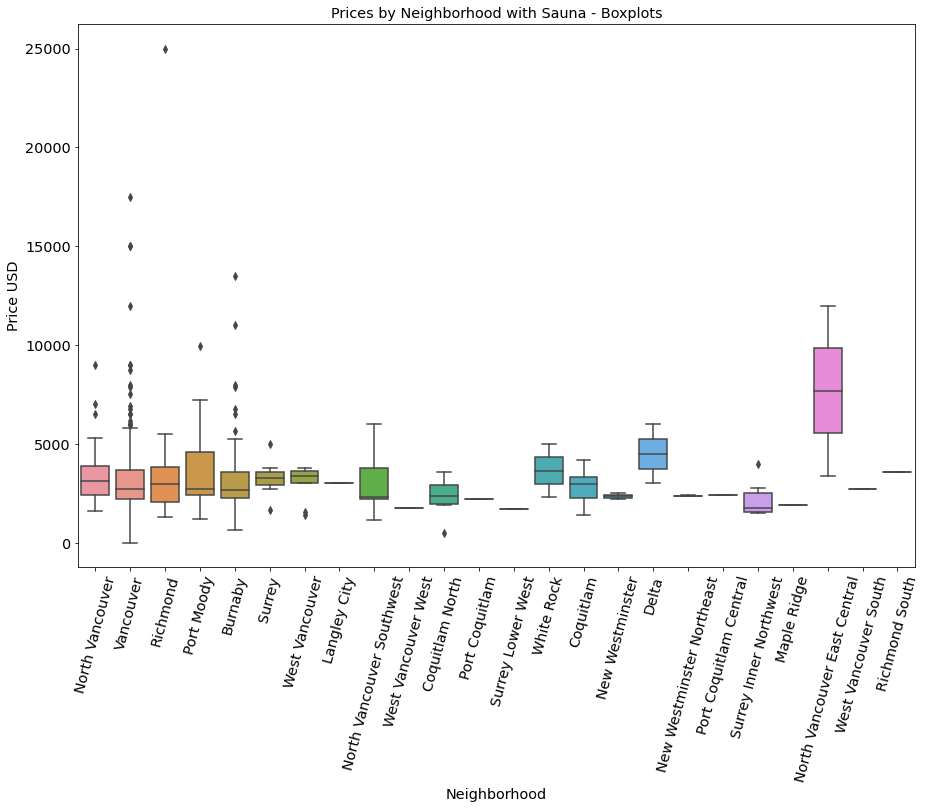

In [20]:
plt.figure(figsize=(15,10))
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

sns.boxplot(x='locality', y='price', data=sauna)
plt.xlabel("Neighborhood");
plt.xticks(rotation=75)
plt.ylabel("Price USD");
plt.title("Prices by Neighborhood with Sauna - Boxplots");

#### Mean Price by Neighborhood without Sauna

In [21]:
no_sauna.groupby('locality').mean()

,price,bedrooms,sqfts,longitude,latitude,bathrooms_level_two,sauna,pool,steam,min_dist
locality,,,,,,,,,,
Abbotsford,2012.750000,2.000000,1103.333333,-123.045319,49.229288,2.750000,0.0,0.250000,0.000000,NaN
Abbotsford East,2100.000000,2.000000,600.000000,-123.012451,49.269260,2.000000,0.0,0.000000,0.000000,NaN
Abbotsford Southwest,4147.500000,4.000000,1100.000000,-122.947180,49.160200,3.000000,0.0,0.333333,0.000000,NaN
Abbotsford West,2300.000000,2.000000,800.000000,-122.900704,49.252691,2.000000,0.0,0.000000,0.000000,NaN
Aldergrove,2850.000000,1.000000,921.250000,-122.830962,49.282128,2.250000,0.0,0.000000,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...
West Vancouver,3281.053691,2.055944,1009.595238,-123.015181,49.239174,1.706667,0.0,0.141975,0.012346,0.652347
West Vancouver North,3030.384615,1.769231,1058.833333,-122.958129,49.192147,1.230769,0.0,0.071429,0.000000,NaN
West Vancouver South,2730.823529,1.928571,932.000000,-122.975298,49.211841,1.647059,0.0,0.000000,0.000000,NaN


In [22]:
no_sauna.groupby('locality').mean()['price'].sort_values()

locality
Campbell River          1100.0
Powell River            1650.0
Sechelt                 1795.0
Salmon Arm              1950.0
Richmond Southeast      1990.0
                         ...  
Ucluelet                4880.0
Kelowna North           5495.0
Furry Creek             6500.0
Harrison Lake Region    8000.0
Mission East            8354.0
Name: price, Length: 88, dtype: float64

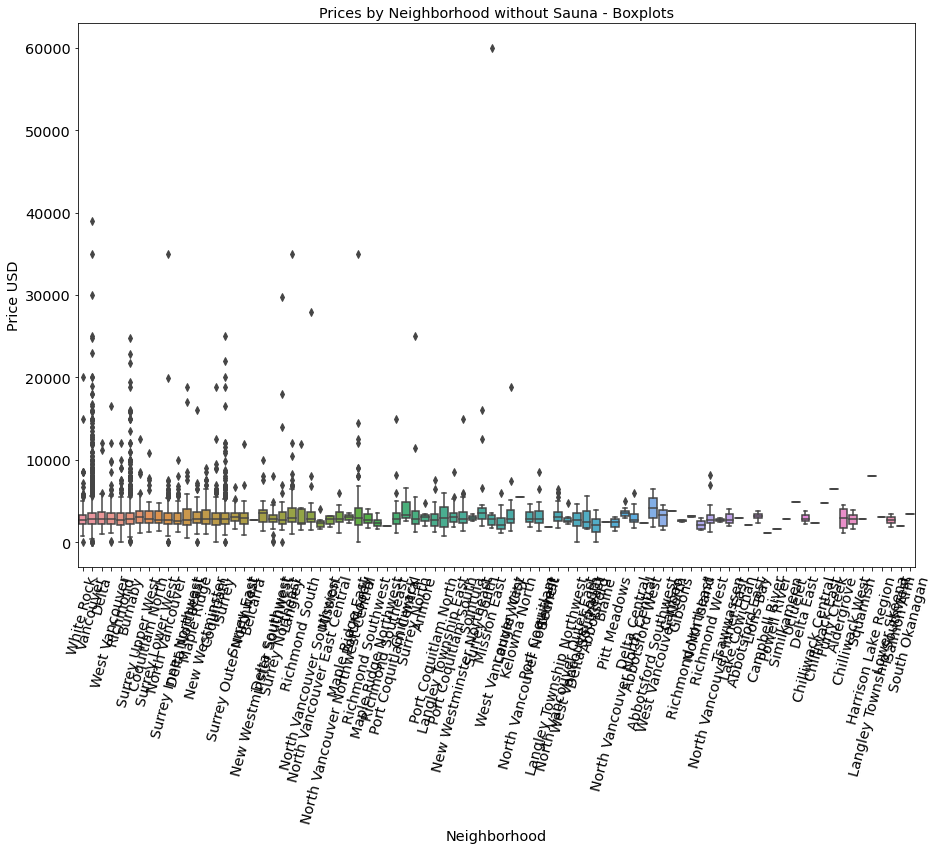

In [23]:
plt.figure(figsize=(15,10))
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

sns.boxplot(x='locality', y='price', data=no_sauna)
plt.xlabel("Neighborhood");
plt.xticks(rotation=75)
plt.ylabel("Price USD");
plt.title("Prices by Neighborhood without Sauna - Boxplots");

In [24]:
from pandas.plotting import scatter_matrix

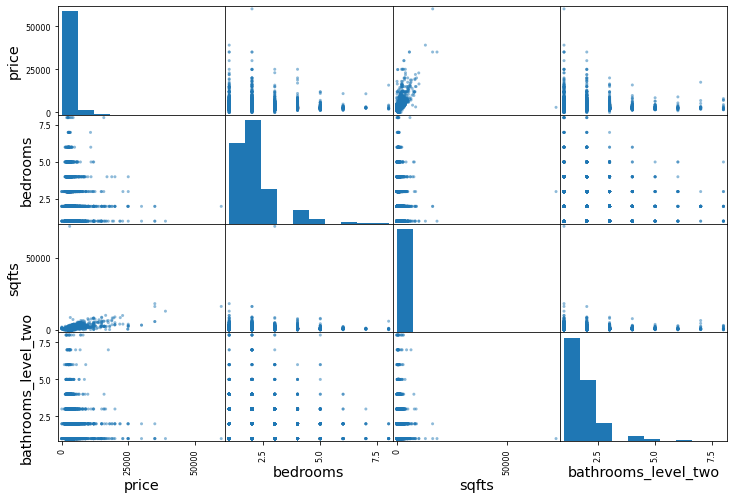

In [25]:
attributes = ["price", "bedrooms", "sqfts", "bathrooms_level_two"]
scatter_matrix(van[attributes].dropna(), figsize=(12, 8))
plt.show()

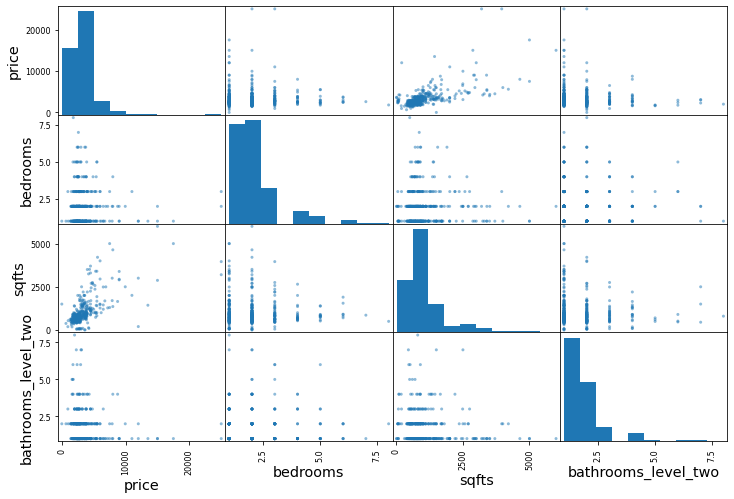

In [26]:
attributes = ["price", "bedrooms", "sqfts", "bathrooms_level_two"]
scatter_matrix(sauna[attributes].dropna(), figsize=(12, 8))
plt.show()

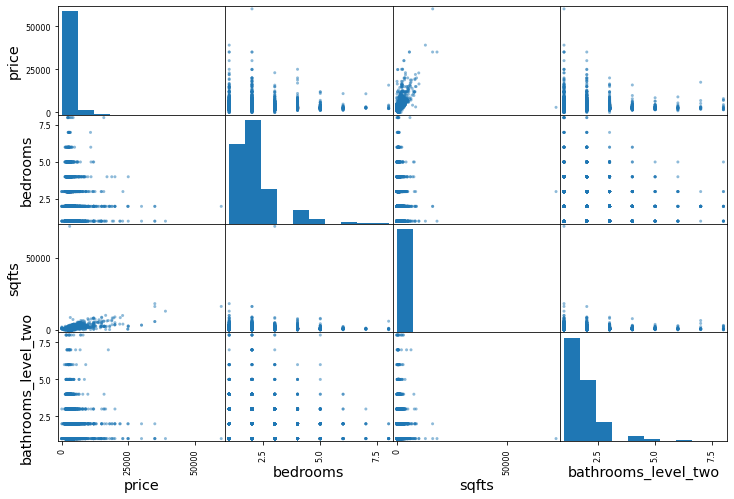

In [27]:
attributes = ["price", "bedrooms", "sqfts", "bathrooms_level_two"]
scatter_matrix(no_sauna[attributes].dropna(), figsize=(12, 8))
plt.show()

## Correlations

In [28]:
van.corr()

,price,bedrooms,sqfts,longitude,latitude,bathrooms_level_two,sauna,pool,steam,min_dist
price,1.000000,-0.017904,0.511656,-0.008580,0.008845,-0.015141,-0.002646,-0.010167,-0.014818,0.003299
bedrooms,-0.017904,1.000000,-0.003945,-0.002620,0.005880,0.008478,-0.007139,-0.001647,-0.003797,0.124240
sqfts,0.511656,-0.003945,1.000000,0.000562,0.000483,-0.008822,-0.000848,-0.010207,-0.011023,-0.009405
longitude,-0.008580,-0.002620,0.000562,1.000000,-0.635601,0.013052,-0.004133,-0.007747,-0.003078,0.172124
latitude,0.008845,0.005880,0.000483,-0.635601,1.000000,-0.003120,0.004664,0.009969,0.004792,0.243666
bathrooms_level_two,-0.015141,0.008478,-0.008822,0.013052,-0.003120,1.000000,-0.000593,0.003881,0.009108,0.061252
sauna,-0.002646,-0.007139,-0.000848,-0.004133,0.004664,-0.000593,1.000000,0.385477,0.430715,0.063297
pool,-0.010167,-0.001647,-0.010207,-0.007747,0.009969,0.003881,0.385477,1.000000,0.286540,-0.037199
steam,-0.014818,-0.003797,-0.011023,-0.003078,0.004792,0.009108,0.430715,0.286540,1.000000,-0.008779
min_dist,0.003299,0.124240,-0.009405,0.172124,0.243666,0.061252,0.063297,-0.037199,-0.008779,1.000000


In [29]:
van['sana_pool_steam_sum'] = van['sauna'] + van['pool'] + van['steam']

In [30]:
van.corr()

,price,bedrooms,sqfts,longitude,latitude,bathrooms_level_two,sauna,pool,steam,min_dist,sana_pool_steam_sum
price,1.000000,-0.017904,0.511656,-0.008580,0.008845,-0.015141,-0.002646,-0.010167,-0.014818,0.003299,-0.010662
bedrooms,-0.017904,1.000000,-0.003945,-0.002620,0.005880,0.008478,-0.007139,-0.001647,-0.003797,0.124240,-0.000142
sqfts,0.511656,-0.003945,1.000000,0.000562,0.000483,-0.008822,-0.000848,-0.010207,-0.011023,-0.009405,-0.013770
longitude,-0.008580,-0.002620,0.000562,1.000000,-0.635601,0.013052,-0.004133,-0.007747,-0.003078,0.172124,-0.008474
latitude,0.008845,0.005880,0.000483,-0.635601,1.000000,-0.003120,0.004664,0.009969,0.004792,0.243666,0.011133
bathrooms_level_two,-0.015141,0.008478,-0.008822,0.013052,-0.003120,1.000000,-0.000593,0.003881,0.009108,0.061252,0.001974
sauna,-0.002646,-0.007139,-0.000848,-0.004133,0.004664,-0.000593,1.000000,0.385477,0.430715,0.063297,0.599500
pool,-0.010167,-0.001647,-0.010207,-0.007747,0.009969,0.003881,0.385477,1.000000,0.286540,-0.037199,0.881244
steam,-0.014818,-0.003797,-0.011023,-0.003078,0.004792,0.009108,0.430715,0.286540,1.000000,-0.008779,0.457610
min_dist,0.003299,0.124240,-0.009405,0.172124,0.243666,0.061252,0.063297,-0.037199,-0.008779,1.000000,0.021677


In [31]:
sauna.corr()

,price,bedrooms,sqfts,longitude,latitude,bathrooms_level_two,sauna,pool,steam,min_dist
price,1.000000,-0.035327,0.623650,-0.060785,-0.008484,-0.081605,NaN,-0.018482,-0.061069,-0.034481
bedrooms,-0.035327,1.000000,-0.059974,0.020899,-0.117252,0.019726,NaN,-0.028825,0.012911,0.259231
sqfts,0.623650,-0.059974,1.000000,-0.064854,0.029788,-0.100681,NaN,0.053953,-0.060845,-0.094965
longitude,-0.060785,0.020899,-0.064854,1.000000,-0.366335,0.049554,NaN,0.023337,-0.078134,0.402295
latitude,-0.008484,-0.117252,0.029788,-0.366335,1.000000,0.004924,NaN,-0.029450,0.073751,0.599523
bathrooms_level_two,-0.081605,0.019726,-0.100681,0.049554,0.004924,1.000000,NaN,0.024984,0.022004,0.425706
sauna,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pool,-0.018482,-0.028825,0.053953,0.023337,-0.029450,0.024984,NaN,1.000000,0.020813,-0.185190
steam,-0.061069,0.012911,-0.060845,-0.078134,0.073751,0.022004,NaN,0.020813,1.000000,-0.091165
min_dist,-0.034481,0.259231,-0.094965,0.402295,0.599523,0.425706,NaN,-0.185190,-0.091165,1.000000


In [32]:
no_sauna.corr()

,price,bedrooms,sqfts,longitude,latitude,bathrooms_level_two,sauna,pool,steam,min_dist
price,1.000000,-0.016588,0.508765,-0.008548,0.009196,-0.010106,NaN,-0.009123,-0.006716,0.007196
bedrooms,-0.016588,1.000000,-0.001241,-0.002878,0.006875,0.007525,NaN,0.004930,-0.004820,0.101125
sqfts,0.508765,-0.001241,1.000000,0.000843,0.000369,-0.004304,NaN,-0.015792,-0.006938,-0.006334
longitude,-0.008548,-0.002878,0.000843,1.000000,-0.635718,0.013332,NaN,-0.007492,-0.000387,0.169941
latitude,0.009196,0.006875,0.000369,-0.635718,1.000000,-0.003301,NaN,0.009944,0.002740,0.196042
bathrooms_level_two,-0.010106,0.007525,-0.004304,0.013332,-0.003301,1.000000,NaN,0.001861,0.008917,0.009149
sauna,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pool,-0.009123,0.004930,-0.015792,-0.007492,0.009944,0.001861,NaN,1.000000,0.212122,-0.032601
steam,-0.006716,-0.004820,-0.006938,-0.000387,0.002740,0.008917,NaN,0.212122,1.000000,-0.003515
min_dist,0.007196,0.101125,-0.006334,0.169941,0.196042,0.009149,NaN,-0.032601,-0.003515,1.000000


### PCA

## KNN Impute

### price	bedrooms	sqfts	longitude	latitude	bathrooms_level_two	sauna	pool	steam

In [33]:
van.columns

Index(['price', 'bedrooms', 'sqfts', 'longitude', 'name', 'latitude',
       'bathrooms_level_two', 'streetAddress', 'country', 'locality', 'postal',
       'region', 'housing_type', 'links', 'sauna', 'pool', 'steam', 'min_dist',
       'min_dist_school_name', 'min_dist_school_type', 'sana_pool_steam_sum'],
      dtype='object')

In [34]:
van_for_pca = van.drop(['name', 'streetAddress', 'country', 'locality', 
                        'postal', 'region','housing_type', 'links',
                        'min_dist_school_name', 'min_dist_school_type'],1)

C:\Users\Daniel\AppData\Local\Temp\ipykernel_17656\1562073112.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  van_for_pca = van.drop(['name', 'streetAddress', 'country', 'locality',


In [35]:
imputer =  KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')

In [36]:
df_imputed = imputer.fit_transform(van_for_pca)

In [37]:
van_for_pca_imputed = pd.DataFrame(df_imputed, columns=van_for_pca.columns)

In [38]:
van_for_pca_imputed

,price,bedrooms,sqfts,longitude,latitude,bathrooms_level_two,sauna,pool,steam,min_dist,sana_pool_steam_sum
0,3000.0,1.0,784.0,-122.812341,49.023295,1.0,0.0,0.0,0.0,0.928307,0.0
1,3495.0,2.0,1000.0,-123.032026,49.312385,2.0,1.0,0.0,1.0,0.200205,1.0
2,5300.0,1.0,733.0,-123.078688,49.310206,1.0,1.0,0.0,1.0,0.909466,1.0
3,4500.0,3.0,1550.0,-123.097900,49.215600,4.0,0.0,0.0,0.0,0.195904,0.0
4,1900.0,1.0,704.0,-123.055115,49.074691,1.0,0.0,0.0,0.0,1.406016,0.0
...,...,...,...,...,...,...,...,...,...,...,...
8658,3295.0,1.0,1100.0,-123.131617,49.282029,1.0,0.0,0.0,0.0,0.459376,0.0
8659,2400.0,4.0,535.0,-122.948402,49.282466,1.6,0.0,0.0,1.0,8.924375,1.0
8660,1870.0,2.0,700.0,-123.113900,49.278800,3.0,0.0,0.0,0.0,0.260564,0.0
8661,3520.0,2.0,885.0,-123.097900,49.215600,3.0,0.0,0.0,0.0,0.260564,0.0


In [39]:
van_for_pca_imputed[['price', 'bedrooms', 'sqfts', 'bathrooms_level_two', 'sauna', 'pool', 'steam']] = van_for_pca_imputed[['price', 'bedrooms', 'sqfts', 'bathrooms_level_two', 'sauna', 'pool', 'steam']].astype(int)

In [40]:
van_for_pca_imputed

,price,bedrooms,sqfts,longitude,latitude,bathrooms_level_two,sauna,pool,steam,min_dist,sana_pool_steam_sum
0,3000,1,784,-122.812341,49.023295,1,0,0,0,0.928307,0.0
1,3495,2,1000,-123.032026,49.312385,2,1,0,1,0.200205,1.0
2,5300,1,733,-123.078688,49.310206,1,1,0,1,0.909466,1.0
3,4500,3,1550,-123.097900,49.215600,4,0,0,0,0.195904,0.0
4,1900,1,704,-123.055115,49.074691,1,0,0,0,1.406016,0.0
...,...,...,...,...,...,...,...,...,...,...,...
8658,3295,1,1100,-123.131617,49.282029,1,0,0,0,0.459376,0.0
8659,2400,4,535,-122.948402,49.282466,1,0,0,1,8.924375,1.0
8660,1870,2,700,-123.113900,49.278800,3,0,0,0,0.260564,0.0
8661,3520,2,885,-123.097900,49.215600,3,0,0,0,0.260564,0.0


In [41]:
scaler = StandardScaler()
#scaler.fit(van_for_pca_imputed)
#van_for_pca_imputed_scaled = scaler.transform(van_for_pca_imputed)
van_for_pca_imputed_scaled = scaler.fit_transform(van_for_pca_imputed)
van_for_pca_imputed_scaled = pd.DataFrame(van_for_pca_imputed_scaled, columns=van_for_pca_imputed.columns)

In [42]:
van_for_pca_imputed_scaled

,price,bedrooms,sqfts,longitude,latitude,bathrooms_level_two,sauna,pool,steam,min_dist,sana_pool_steam_sum
0,-0.125106,-0.968003,-0.219017,0.079744,-0.206022,-0.673758,-0.272789,-0.40099,-0.208225,0.509149,-0.455028
1,0.086681,-0.017662,-0.034671,-0.031437,0.105236,0.371883,3.665833,-0.40099,4.802488,-0.365839,2.197668
2,0.858956,-0.968003,-0.262543,-0.055052,0.102890,-0.673758,3.665833,-0.40099,4.802488,0.486506,2.197668
3,0.516674,0.932679,0.434730,-0.064775,0.001030,2.463165,-0.272789,-0.40099,-0.208225,-0.371007,-0.455028
4,-0.595745,-0.968003,-0.287293,-0.043122,-0.150685,-0.673758,-0.272789,-0.40099,-0.208225,1.083228,-0.455028
...,...,...,...,...,...,...,...,...,...,...,...
8658,0.001111,-0.968003,0.050675,-0.081839,0.072553,-0.673758,-0.272789,-0.40099,-0.208225,-0.054384,-0.455028
8659,-0.381818,1.883020,-0.431528,0.010885,0.073023,-0.673758,-0.272789,-0.40099,4.802488,10.118316,2.197668
8660,-0.608580,-0.017662,-0.290707,-0.072872,0.069076,1.417524,-0.272789,-0.40099,-0.208225,-0.293303,-0.455028
8661,0.097378,-0.017662,-0.132818,-0.064775,0.001030,1.417524,-0.272789,-0.40099,-0.208225,-0.293303,-0.455028


In [43]:
pca = PCA()
pca_components = pca.fit_transform(van_for_pca_imputed_scaled)

In [44]:
explained_var = pd.DataFrame([pca.explained_variance_ratio_], columns = van_for_pca_imputed_scaled.columns)

In [45]:
explained_var

,price,bedrooms,sqfts,longitude,latitude,bathrooms_level_two,sauna,pool,steam,min_dist,sana_pool_steam_sum
0,0.232991,0.148793,0.137381,0.099427,0.090774,0.082561,0.073995,0.049646,0.044343,0.033104,0.006985


### price,	bedrooms,	sqfts,	bathrooms,  sauna,	pool,	steam

In [46]:
van_for_pca = van.drop(['name', 'streetAddress', 'country', 'locality', 
                        'postal', 'region','housing_type', 'links',
                        'min_dist_school_name', 'min_dist_school_type', 'longitude', 'latitude'],1)

C:\Users\Daniel\AppData\Local\Temp\ipykernel_17656\2326779941.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  van_for_pca = van.drop(['name', 'streetAddress', 'country', 'locality',


In [47]:
imputer =  KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')

In [48]:
df_imputed = imputer.fit_transform(van_for_pca)

In [49]:
van_for_pca_imputed = pd.DataFrame(df_imputed, columns=van_for_pca.columns)

In [50]:
van_for_pca_imputed

,price,bedrooms,sqfts,bathrooms_level_two,sauna,pool,steam,min_dist,sana_pool_steam_sum
0,3000.0,1.0,784.0,1.0,0.0,0.0,0.0,0.928307,0.0
1,3495.0,2.0,1000.0,2.0,1.0,0.0,1.0,0.200205,1.0
2,5300.0,1.0,733.0,1.0,1.0,0.0,1.0,0.909466,1.0
3,4500.0,3.0,1550.0,4.0,0.0,0.0,0.0,0.195904,0.0
4,1900.0,1.0,546.0,1.0,0.0,0.0,0.0,1.406016,0.0
...,...,...,...,...,...,...,...,...,...
8658,3295.0,1.0,1100.0,1.0,0.0,0.0,0.0,0.459376,0.0
8659,2400.0,4.0,535.0,1.6,0.0,0.0,1.0,8.933179,1.0
8660,1870.0,2.0,700.0,3.0,0.0,0.0,0.0,0.503354,0.0
8661,3520.0,2.0,885.0,3.0,0.0,0.0,0.0,0.386281,0.0


In [51]:
van_for_pca_imputed[['price', 'bedrooms', 'sqfts', 'bathrooms_level_two', 'sauna', 'pool', 'steam', 'sana_pool_steam_sum']] = van_for_pca_imputed[['price', 'bedrooms', 'sqfts', 'bathrooms_level_two', 'sauna', 'pool', 'steam', 'sana_pool_steam_sum']].astype(int)

In [52]:
van_for_pca_imputed

,price,bedrooms,sqfts,bathrooms_level_two,sauna,pool,steam,min_dist,sana_pool_steam_sum
0,3000,1,784,1,0,0,0,0.928307,0
1,3495,2,1000,2,1,0,1,0.200205,1
2,5300,1,733,1,1,0,1,0.909466,1
3,4500,3,1550,4,0,0,0,0.195904,0
4,1900,1,546,1,0,0,0,1.406016,0
...,...,...,...,...,...,...,...,...,...
8658,3295,1,1100,1,0,0,0,0.459376,0
8659,2400,4,535,1,0,0,1,8.933179,1
8660,1870,2,700,3,0,0,0,0.503354,0
8661,3520,2,885,3,0,0,0,0.386281,0


In [53]:
scaler = StandardScaler()
#scaler.fit(van_for_pca_imputed)
#van_for_pca_imputed_scaled = scaler.transform(van_for_pca_imputed)
van_for_pca_imputed_scaled = scaler.fit_transform(van_for_pca_imputed)
van_for_pca_imputed_scaled = pd.DataFrame(van_for_pca_imputed_scaled, columns=van_for_pca_imputed.columns)

In [54]:
van_for_pca_imputed_scaled

,price,bedrooms,sqfts,bathrooms_level_two,sauna,pool,steam,min_dist,sana_pool_steam_sum
0,-0.128474,-0.960555,-0.210706,-0.681056,-0.272789,-0.40099,-0.208225,0.465381,-0.455028
1,0.084112,-0.011828,-0.024502,0.365413,3.665833,-0.40099,4.802488,-0.388122,2.197668
2,0.859300,-0.960555,-0.254670,-0.681056,3.665833,-0.40099,4.802488,0.443294,2.197668
3,0.515726,0.936900,0.449629,2.458351,-0.272789,-0.40099,-0.208225,-0.393163,-0.455028
4,-0.600888,-0.960555,-0.415875,-0.681056,-0.272789,-0.40099,-0.208225,1.025365,-0.455028
...,...,...,...,...,...,...,...,...,...
8658,-0.001781,-0.960555,0.061704,-0.681056,-0.272789,-0.40099,-0.208225,-0.084314,-0.455028
8659,-0.386154,1.885628,-0.425357,-0.681056,-0.272789,-0.40099,4.802488,9.848925,2.197668
8660,-0.613772,-0.011828,-0.283118,1.411882,-0.272789,-0.40099,-0.208225,-0.032762,-0.455028
8661,0.094849,-0.011828,-0.123638,1.411882,-0.272789,-0.40099,-0.208225,-0.169998,-0.455028


In [55]:
pca = PCA()
pca_components = pca.fit_transform(van_for_pca_imputed_scaled)

In [56]:
explained_var = pd.DataFrame([pca.explained_variance_ratio_], columns = van_for_pca_imputed_scaled.columns)

In [57]:
explained_var

,price,bedrooms,sqfts,bathrooms_level_two,sauna,pool,steam,min_dist,sana_pool_steam_sum
0,0.284531,0.168822,0.121587,0.111175,0.100985,0.090217,0.060677,0.053466,0.00854


## Iterative Impute

### price	bedrooms	sqfts	longitude	latitude	bathrooms_level_two	sauna	pool	steam

In [58]:
van_for_pca = van.drop(['name', 'streetAddress', 'country', 'locality', 
                        'postal', 'region','housing_type', 'links',
                        'min_dist_school_name', 'min_dist_school_type'],1)

C:\Users\Daniel\AppData\Local\Temp\ipykernel_17656\1562073112.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  van_for_pca = van.drop(['name', 'streetAddress', 'country', 'locality',


In [59]:
imputer = IterativeImputer(random_state=42)

In [60]:
df_imputed = imputer.fit_transform(van_for_pca)

In [61]:
van_for_pca_imputed = pd.DataFrame(df_imputed, columns=van_for_pca.columns)

In [62]:
van_for_pca_imputed

,price,bedrooms,sqfts,longitude,latitude,bathrooms_level_two,sauna,pool,steam,min_dist,sana_pool_steam_sum
0,3000.0,1.0,784.000000,-122.812341,49.023295,1.000000,0.0,0.0,0.0,0.928307,0.0
1,3495.0,2.0,1000.000000,-123.032026,49.312385,2.000000,1.0,0.0,1.0,0.200205,1.0
2,5300.0,1.0,733.000000,-123.078688,49.310206,1.000000,1.0,0.0,1.0,0.909466,1.0
3,4500.0,3.0,1550.000000,-123.097900,49.215600,4.000000,0.0,0.0,0.0,0.195904,0.0
4,1900.0,1.0,666.608691,-123.055115,49.074691,1.000000,0.0,0.0,0.0,1.406016,0.0
...,...,...,...,...,...,...,...,...,...,...,...
8658,3295.0,1.0,1100.000000,-123.131617,49.282029,1.000000,0.0,0.0,0.0,0.355790,0.0
8659,2400.0,4.0,535.000000,-122.948402,49.282466,1.725154,0.0,0.0,1.0,2.330947,1.0
8660,1870.0,2.0,700.000000,-123.113900,49.278800,3.000000,0.0,0.0,0.0,1.079686,0.0
8661,3520.0,2.0,885.000000,-123.097900,49.215600,3.000000,0.0,0.0,0.0,0.575111,0.0


In [63]:
van_for_pca_imputed[['price', 'bedrooms', 'sqfts', 'bathrooms_level_two', 'sauna', 'pool', 'steam']] = van_for_pca_imputed[['price', 'bedrooms', 'sqfts', 'bathrooms_level_two', 'sauna', 'pool', 'steam']].astype(int)

In [64]:
van_for_pca_imputed

,price,bedrooms,sqfts,longitude,latitude,bathrooms_level_two,sauna,pool,steam,min_dist,sana_pool_steam_sum
0,3000,1,784,-122.812341,49.023295,1,0,0,0,0.928307,0.0
1,3495,2,1000,-123.032026,49.312385,2,1,0,1,0.200205,1.0
2,5300,1,733,-123.078688,49.310206,1,1,0,1,0.909466,1.0
3,4500,3,1550,-123.097900,49.215600,4,0,0,0,0.195904,0.0
4,1900,1,666,-123.055115,49.074691,1,0,0,0,1.406016,0.0
...,...,...,...,...,...,...,...,...,...,...,...
8658,3295,1,1100,-123.131617,49.282029,1,0,0,0,0.355790,0.0
8659,2400,4,535,-122.948402,49.282466,1,0,0,1,2.330947,1.0
8660,1870,2,700,-123.113900,49.278800,3,0,0,0,1.079686,0.0
8661,3520,2,885,-123.097900,49.215600,3,0,0,0,0.575111,0.0


In [65]:
scaler = StandardScaler()
#scaler.fit(van_for_pca_imputed)
#van_for_pca_imputed_scaled = scaler.transform(van_for_pca_imputed)
van_for_pca_imputed_scaled = scaler.fit_transform(van_for_pca_imputed)
van_for_pca_imputed_scaled = pd.DataFrame(van_for_pca_imputed_scaled, columns=van_for_pca_imputed.columns)

In [66]:
van_for_pca_imputed_scaled

,price,bedrooms,sqfts,longitude,latitude,bathrooms_level_two,sauna,pool,steam,min_dist,sana_pool_steam_sum
0,-0.125582,-1.001556,-0.213622,0.079094,-0.204886,-0.651476,-0.272789,-0.40099,-0.208225,0.036532,-0.455028
1,0.087921,-0.035893,-0.026039,-0.032094,0.106396,0.391536,3.665833,-0.40099,4.802488,-0.080336,2.197668
2,0.866452,-1.001556,-0.257913,-0.055711,0.104050,-0.651476,3.665833,-0.40099,4.802488,0.033508,2.197668
3,0.521397,0.929770,0.451604,-0.065435,0.002181,2.477561,-0.272789,-0.40099,-0.208225,-0.081026,-0.455028
4,-0.600033,-1.001556,-0.316099,-0.043780,-0.149544,-0.651476,-0.272789,-0.40099,-0.208225,0.113209,-0.455028
...,...,...,...,...,...,...,...,...,...,...,...
8658,0.001657,-1.001556,0.060805,-0.082500,0.073710,-0.651476,-0.272789,-0.40099,-0.208225,-0.055363,-0.455028
8659,-0.384374,1.895433,-0.429864,0.010230,0.074180,-0.651476,-0.272789,-0.40099,4.802488,0.261670,2.197668
8660,-0.612973,-0.035893,-0.286572,-0.073533,0.070233,1.434548,-0.272789,-0.40099,-0.208225,0.060830,-0.455028
8661,0.098704,-0.035893,-0.125910,-0.065435,0.002181,1.434548,-0.272789,-0.40099,-0.208225,-0.020159,-0.455028


In [67]:
pca = PCA()
pca_components = pca.fit_transform(van_for_pca_imputed_scaled)

In [68]:
explained_var = pd.DataFrame([pca.explained_variance_ratio_], columns = van_for_pca_imputed_scaled.columns)

In [69]:
explained_var

,price,bedrooms,sqfts,longitude,latitude,bathrooms_level_two,sauna,pool,steam,min_dist,sana_pool_steam_sum
0,0.232869,0.168294,0.138836,0.10542,0.090219,0.090119,0.074063,0.049794,0.043024,0.007012,0.00035


### price,	bedrooms,	sqfts,	bathrooms,  sauna,	pool,	steam

In [70]:
van_for_pca = van.drop(['name', 'streetAddress', 'country', 'locality', 
                        'postal', 'region','housing_type', 'links',
                        'min_dist_school_name', 'min_dist_school_type', 'longitude', 'latitude'],1)

C:\Users\Daniel\AppData\Local\Temp\ipykernel_17656\2326779941.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  van_for_pca = van.drop(['name', 'streetAddress', 'country', 'locality',


In [71]:
imputer = IterativeImputer(random_state=42)

In [72]:
df_imputed = imputer.fit_transform(van_for_pca)

In [73]:
van_for_pca_imputed = pd.DataFrame(df_imputed, columns=van_for_pca.columns)

In [74]:
van_for_pca_imputed

,price,bedrooms,sqfts,bathrooms_level_two,sauna,pool,steam,min_dist,sana_pool_steam_sum
0,3000.0,1.0,784.000000,1.000000,0.0,0.0,0.0,0.928307,0.0
1,3495.0,2.0,1000.000000,2.000000,1.0,0.0,1.0,0.200205,1.0
2,5300.0,1.0,733.000000,1.000000,1.0,0.0,1.0,0.909466,1.0
3,4500.0,3.0,1550.000000,4.000000,0.0,0.0,0.0,0.195904,0.0
4,1900.0,1.0,666.608612,1.000000,0.0,0.0,0.0,1.406016,0.0
...,...,...,...,...,...,...,...,...,...
8658,3295.0,1.0,1100.000000,1.000000,0.0,0.0,0.0,0.493884,0.0
8659,2400.0,4.0,535.000000,1.719231,0.0,0.0,1.0,1.216848,1.0
8660,1870.0,2.0,700.000000,3.000000,0.0,0.0,0.0,0.878385,0.0
8661,3520.0,2.0,885.000000,3.000000,0.0,0.0,0.0,0.888178,0.0


In [75]:
van_for_pca_imputed[['price', 'bedrooms', 'sqfts', 'bathrooms_level_two', 'sauna', 'pool', 'steam']] = van_for_pca_imputed[['price', 'bedrooms', 'sqfts', 'bathrooms_level_two', 'sauna', 'pool', 'steam']].astype(int)

In [76]:
van_for_pca_imputed

,price,bedrooms,sqfts,bathrooms_level_two,sauna,pool,steam,min_dist,sana_pool_steam_sum
0,3000,1,784,1,0,0,0,0.928307,0.0
1,3495,2,1000,2,1,0,1,0.200205,1.0
2,5300,1,733,1,1,0,1,0.909466,1.0
3,4500,3,1550,4,0,0,0,0.195904,0.0
4,1900,1,666,1,0,0,0,1.406016,0.0
...,...,...,...,...,...,...,...,...,...
8658,3295,1,1100,1,0,0,0,0.493884,0.0
8659,2400,4,535,1,0,0,1,1.216848,1.0
8660,1870,2,700,3,0,0,0,0.878385,0.0
8661,3520,2,885,3,0,0,0,0.888178,0.0


In [77]:
scaler = StandardScaler()
#scaler.fit(van_for_pca_imputed)
#van_for_pca_imputed_scaled = scaler.transform(van_for_pca_imputed)
van_for_pca_imputed_scaled = scaler.fit_transform(van_for_pca_imputed)
van_for_pca_imputed_scaled = pd.DataFrame(van_for_pca_imputed_scaled, columns=van_for_pca_imputed.columns)

In [78]:
van_for_pca_imputed_scaled

,price,bedrooms,sqfts,bathrooms_level_two,sauna,pool,steam,min_dist,sana_pool_steam_sum
0,-0.125582,-1.002234,-0.213622,-0.651476,-0.272789,-0.40099,-0.208225,0.180900,-0.455028
1,0.087921,-0.036348,-0.026038,0.391536,3.665833,-0.40099,4.802488,-0.698146,2.197668
2,0.866452,-1.002234,-0.257912,-0.651476,3.665833,-0.40099,4.802488,0.158152,2.197668
3,0.521396,0.929539,0.451605,2.477561,-0.272789,-0.40099,-0.208225,-0.703339,-0.455028
4,-0.600034,-1.002234,-0.316098,-0.651476,-0.272789,-0.40099,-0.208225,0.757642,-0.455028
...,...,...,...,...,...,...,...,...,...
8658,0.001657,-1.002234,0.060806,-0.651476,-0.272789,-0.40099,-0.208225,-0.343584,-0.455028
8659,-0.384374,1.895425,-0.429863,-0.651476,-0.272789,-0.40099,4.802488,0.529257,2.197668
8660,-0.612973,-0.036348,-0.286571,1.434548,-0.272789,-0.40099,-0.208225,0.120628,-0.455028
8661,0.098704,-0.036348,-0.125909,1.434548,-0.272789,-0.40099,-0.208225,0.132451,-0.455028


In [79]:
pca = PCA()
pca_components = pca.fit_transform(van_for_pca_imputed_scaled)

In [80]:
explained_var = pd.DataFrame([pca.explained_variance_ratio_], columns = van_for_pca_imputed_scaled.columns)

In [81]:
explained_var

,price,bedrooms,sqfts,bathrooms_level_two,sauna,pool,steam,min_dist,sana_pool_steam_sum
0,0.284547,0.169744,0.143937,0.110555,0.090812,0.078971,0.060392,0.052504,0.008538


In [82]:
import statsmodels.api as sm


van_for_pca_imputed_scaled[['price', 'bedrooms', 'sqfts', 'bathrooms_level_two', 'sauna', 'pool', 'steam']] = van_for_pca_imputed_scaled[['price', 'bedrooms', 'sqfts', 'bathrooms_level_two', 'sauna', 'pool', 'steam']].astype(int)

X = van_for_pca_imputed_scaled[['bedrooms', 'sqfts', 'bathrooms_level_two', 'sauna', 'pool', 'steam', 'min_dist']]
y = van_for_pca_imputed_scaled['price']

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.184
Model:                            OLS   Adj. R-squared:                  0.184
Method:                 Least Squares   F-statistic:                     279.7
Date:                Mon, 27 Mar 2023   Prob (F-statistic):               0.00
Time:                        21:46:35   Log-Likelihood:                -9651.2
No. Observations:                8663   AIC:                         1.932e+04
Df Residuals:                    8655   BIC:                         1.937e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0885    

## No Impute, drop all rows where any column is NaN

### price	bedrooms	sqfts	longitude	latitude	bathrooms_level_two	sauna	pool	steam

In [83]:
van_for_pca = van.drop(['name', 'streetAddress', 'country', 'locality', 
                        'postal', 'region','housing_type', 'links',
                        'min_dist_school_name', 'min_dist_school_type'],1)

C:\Users\Daniel\AppData\Local\Temp\ipykernel_17656\1562073112.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  van_for_pca = van.drop(['name', 'streetAddress', 'country', 'locality',


In [84]:
van_for_pca_dropna = van_for_pca.dropna()

In [85]:
scaler = StandardScaler()
#scaler.fit(van_for_pca_imputed)
#van_for_pca_imputed_scaled = scaler.transform(van_for_pca_imputed)
van_for_pca_dropna_scaled = scaler.fit_transform(van_for_pca_dropna)
van_for_pca_dropna_scaled = pd.DataFrame(van_for_pca_dropna_scaled, columns=van_for_pca_dropna.columns)

In [86]:
van_for_pca_dropna_scaled

,price,bedrooms,sqfts,longitude,latitude,bathrooms_level_two,sauna,pool,steam,min_dist,sana_pool_steam_sum
0,-0.157212,-1.014090,-0.121859,0.664224,-2.014866,-0.684768,-0.287612,-0.410671,-0.227565,0.035088,-0.476533
1,0.053439,0.043076,-0.050806,-0.130058,0.734460,0.399448,3.476908,-0.410671,4.394354,-0.203875,2.098492
2,0.821568,-1.014090,-0.138636,-0.298767,0.713737,-0.684768,3.476908,-0.410671,4.394354,0.028904,2.098492
3,0.481123,1.100243,0.130116,-0.368229,-0.185992,2.567881,-0.287612,-0.410671,-0.227565,-0.205286,-0.476533
4,0.393884,0.043076,0.023207,-0.483565,0.457854,0.399448,-0.287612,-0.410671,-0.227565,-0.253885,-0.476533
...,...,...,...,...,...,...,...,...,...,...,...
584,-0.242323,0.043076,-0.100149,1.130648,-1.060072,-0.684768,-0.287612,-0.410671,-0.227565,-0.098077,-0.476533
585,0.523679,0.043076,-0.067254,-0.448299,0.422304,0.399448,-0.287612,-0.410671,-0.227565,-0.141246,-0.476533
586,2.183348,0.043076,0.113668,0.490280,-0.500040,-0.684768,-0.287612,-0.410671,-0.227565,-0.086470,-0.476533
587,-0.625324,1.100243,-0.177780,0.653667,-0.226705,0.399448,-0.287612,-0.410671,-0.227565,-0.143064,-0.476533


In [87]:
pca = PCA()
pca_components = pca.fit_transform(van_for_pca_dropna_scaled)

In [88]:
explained_var = pd.DataFrame([pca.explained_variance_ratio_], columns = van_for_pca_dropna_scaled.columns)

In [89]:
explained_var

,price,bedrooms,sqfts,longitude,latitude,bathrooms_level_two,sauna,pool,steam,min_dist,sana_pool_steam_sum
0,0.239517,0.122388,0.119716,0.107995,0.093763,0.078428,0.073249,0.067536,0.050207,0.039555,0.007645


### price,	bedrooms,	sqfts,	bathrooms,  sauna,	pool,	steam

In [90]:
van_for_pca = van.drop(['name', 'streetAddress', 'country', 'locality', 
                        'postal', 'region','housing_type', 'links',
                        'min_dist_school_name', 'min_dist_school_type', 'longitude', 'latitude'],1)

C:\Users\Daniel\AppData\Local\Temp\ipykernel_17656\2326779941.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  van_for_pca = van.drop(['name', 'streetAddress', 'country', 'locality',


In [91]:
van_for_pca_dropna = van_for_pca.dropna()

In [92]:
scaler = StandardScaler()
#scaler.fit(van_for_pca_imputed)
#van_for_pca_imputed_scaled = scaler.transform(van_for_pca_imputed)
van_for_pca_dropna_scaled = scaler.fit_transform(van_for_pca_dropna)
van_for_pca_dropna_scaled = pd.DataFrame(van_for_pca_dropna_scaled, columns=van_for_pca_dropna.columns)

In [93]:
van_for_pca_dropna_scaled

,price,bedrooms,sqfts,bathrooms_level_two,sauna,pool,steam,min_dist,sana_pool_steam_sum
0,-0.157212,-1.014090,-0.121859,-0.684768,-0.287612,-0.410671,-0.227565,0.035088,-0.476533
1,0.053439,0.043076,-0.050806,0.399448,3.476908,-0.410671,4.394354,-0.203875,2.098492
2,0.821568,-1.014090,-0.138636,-0.684768,3.476908,-0.410671,4.394354,0.028904,2.098492
3,0.481123,1.100243,0.130116,2.567881,-0.287612,-0.410671,-0.227565,-0.205286,-0.476533
4,0.393884,0.043076,0.023207,0.399448,-0.287612,-0.410671,-0.227565,-0.253885,-0.476533
...,...,...,...,...,...,...,...,...,...
584,-0.242323,0.043076,-0.100149,-0.684768,-0.287612,-0.410671,-0.227565,-0.098077,-0.476533
585,0.523679,0.043076,-0.067254,0.399448,-0.287612,-0.410671,-0.227565,-0.141246,-0.476533
586,2.183348,0.043076,0.113668,-0.684768,-0.287612,-0.410671,-0.227565,-0.086470,-0.476533
587,-0.625324,1.100243,-0.177780,0.399448,-0.287612,-0.410671,-0.227565,-0.143064,-0.476533


In [94]:
pca = PCA()
pca_components = pca.fit_transform(van_for_pca_dropna_scaled)

In [95]:
explained_var = pd.DataFrame([pca.explained_variance_ratio_], columns = van_for_pca_dropna_scaled.columns)

In [96]:
explained_var

,price,bedrooms,sqfts,bathrooms_level_two,sauna,pool,steam,min_dist,sana_pool_steam_sum
0,0.283894,0.138817,0.132024,0.106596,0.096828,0.089837,0.082493,0.0601,0.009412


In [97]:
van_for_pca_dropna

,price,bedrooms,sqfts,bathrooms_level_two,sauna,pool,steam,min_dist,sana_pool_steam_sum
0,3000.0,1.0,784.0,1.0,False,False,False,0.928307,False
1,3495.0,2.0,1000.0,2.0,True,False,True,0.200205,True
2,5300.0,1.0,733.0,1.0,True,False,True,0.909466,True
3,4500.0,3.0,1550.0,4.0,False,False,False,0.195904,False
5,4295.0,2.0,1225.0,2.0,False,False,False,0.047825,False
...,...,...,...,...,...,...,...,...,...
795,2800.0,2.0,850.0,1.0,False,False,False,0.522564,False
797,4600.0,2.0,950.0,2.0,False,False,False,0.391030,False
798,8500.0,2.0,1500.0,1.0,False,False,False,0.557928,False
800,1900.0,3.0,614.0,2.0,False,False,False,0.385491,False


In [98]:
van_for_pca_dropna

,price,bedrooms,sqfts,bathrooms_level_two,sauna,pool,steam,min_dist,sana_pool_steam_sum
0,3000.0,1.0,784.0,1.0,False,False,False,0.928307,False
1,3495.0,2.0,1000.0,2.0,True,False,True,0.200205,True
2,5300.0,1.0,733.0,1.0,True,False,True,0.909466,True
3,4500.0,3.0,1550.0,4.0,False,False,False,0.195904,False
5,4295.0,2.0,1225.0,2.0,False,False,False,0.047825,False
...,...,...,...,...,...,...,...,...,...
795,2800.0,2.0,850.0,1.0,False,False,False,0.522564,False
797,4600.0,2.0,950.0,2.0,False,False,False,0.391030,False
798,8500.0,2.0,1500.0,1.0,False,False,False,0.557928,False
800,1900.0,3.0,614.0,2.0,False,False,False,0.385491,False


In [99]:
import statsmodels.api as sm


van_for_pca_dropna[['price', 'bedrooms', 'sqfts', 'bathrooms_level_two', 'sauna', 'pool', 'steam']] = van_for_pca_dropna[['price', 'bedrooms', 'sqfts', 'bathrooms_level_two', 'sauna', 'pool', 'steam']].astype(int)

X = van_for_pca_dropna[['bedrooms', 'sqfts', 'bathrooms_level_two', 'sauna', 'pool', 'steam', 'min_dist']]
y = van_for_pca_dropna['price']

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     4.614
Date:                Mon, 27 Mar 2023   Prob (F-statistic):           4.88e-05
Time:                        21:46:35   Log-Likelihood:                -5391.7
No. Observations:                 589   AIC:                         1.080e+04
Df Residuals:                     581   BIC:                         1.083e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                3169.3248    

C:\Users\Daniel\AppData\Local\Temp\ipykernel_17656\3542281252.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  van_for_pca_dropna[['price', 'bedrooms', 'sqfts', 'bathrooms_level_two', 'sauna', 'pool', 'steam']] = van_for_pca_dropna[['price', 'bedrooms', 'sqfts', 'bathrooms_level_two', 'sauna', 'pool', 'steam']].astype(int)


### Bedrooms and Sqft

In [100]:
X = van_for_pca_dropna[['bedrooms', 'sqfts']]
y = van_for_pca_dropna['price']

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     9.854
Date:                Mon, 27 Mar 2023   Prob (F-statistic):           6.18e-05
Time:                        21:46:35   Log-Likelihood:                -5397.9
No. Observations:                 589   AIC:                         1.080e+04
Df Residuals:                     586   BIC:                         1.081e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3225.3303    221.338     14.572      0.0

In [101]:
X = van_for_pca_dropna[['bathrooms_level_two', 'sauna', 'pool', 'steam']]
y = van_for_pca_dropna['price']

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     3.047
Date:                Mon, 27 Mar 2023   Prob (F-statistic):             0.0167
Time:                        21:46:35   Log-Likelihood:                -5401.6
No. Observations:                 589   AIC:                         1.081e+04
Df Residuals:                     584   BIC:                         1.084e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                3342.2857    

## Factor Analysis

### Drop Na

#### price	bedrooms	sqfts	longitude	latitude	bathrooms_level_two	sauna	pool	steam

In [102]:
from sklearn.decomposition import FactorAnalysis
drop = ['name', 'streetAddress', 'country', 'locality', 
                        'postal', 'region','housing_type', 'links',
                        'min_dist_school_name', 'min_dist_school_type']
van_for_factor = van.drop(drop,1)

C:\Users\Daniel\AppData\Local\Temp\ipykernel_17656\6174738.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  van_for_factor = van.drop(drop,1)


In [103]:
van_for_factor_dropna = van_for_factor.dropna()

In [104]:
scaler = StandardScaler()
#scaler.fit(van_for_pca_imputed)
#van_for_pca_imputed_scaled = scaler.transform(van_for_pca_imputed)
van_for_factor_dropna_scaled = scaler.fit_transform(van_for_factor_dropna)
van_for_factor_dropna_scaled = pd.DataFrame(van_for_factor_dropna_scaled, columns=van_for_factor_dropna.columns)

In [105]:
fa = FactorAnalysis(n_components=len(van_for_factor_dropna_scaled.columns))


In [106]:
fa_fit_transform= fa.fit_transform(van_for_factor_dropna_scaled)

In [107]:
fa.get_feature_names_out(input_features = van_for_factor_dropna_scaled.columns)

array(['factoranalysis0', 'factoranalysis1', 'factoranalysis2',
       'factoranalysis3', 'factoranalysis4', 'factoranalysis5',
       'factoranalysis6', 'factoranalysis7', 'factoranalysis8',
       'factoranalysis9', 'factoranalysis10'], dtype=object)

In [108]:
fa.feature_names_in_

array(['price', 'bedrooms', 'sqfts', 'longitude', 'latitude',
       'bathrooms_level_two', 'sauna', 'pool', 'steam', 'min_dist',
       'sana_pool_steam_sum'], dtype=object)

In [109]:
covar = pd.DataFrame(fa.get_covariance(), columns = fa.feature_names_in_, index = fa.feature_names_in_)

In [110]:
covar

,price,bedrooms,sqfts,longitude,latitude,bathrooms_level_two,sauna,pool,steam,min_dist,sana_pool_steam_sum
price,1.053682,0.012613,0.138302,-0.008546,0.016564,-0.021728,0.086685,0.046650,0.039564,0.005158,0.065125
bedrooms,0.012613,1.049630,0.022470,0.117867,-0.011244,0.101367,0.006776,-0.043467,0.003086,0.137932,-0.033164
sqfts,0.138302,0.022470,1.041880,-0.003432,0.003517,-0.006135,0.025109,-0.013217,-0.009209,-0.002411,-0.007524
longitude,-0.008546,0.117867,-0.003432,1.120143,-0.251501,0.018828,-0.070224,-0.141300,-0.050613,0.066885,-0.148895
latitude,0.016564,-0.011244,0.003517,-0.251501,1.129936,0.013116,0.111637,0.119415,0.060561,0.150590,0.153327
bathrooms_level_two,-0.021728,0.101367,-0.006135,0.018828,0.013116,1.047923,-0.020084,0.025103,-0.019484,0.052981,0.009860
sauna,0.086685,0.006776,0.025109,-0.070224,0.111637,-0.020084,1.098577,0.438360,0.364462,0.053475,0.527023
pool,0.046650,-0.043467,-0.013217,-0.141300,0.119415,0.025103,0.438360,1.202672,0.347460,-0.018364,0.666880
steam,0.039564,0.003086,-0.009209,-0.050613,0.060561,-0.019484,0.364462,0.347460,1.077092,0.015490,0.426773
min_dist,0.005158,0.137932,-0.002411,0.066885,0.150590,0.052981,0.053475,-0.018364,0.015490,1.111081,0.014117


#### price	bedrooms	sqfts	bathrooms_level_two	sauna	pool	steam

In [111]:
from sklearn.decomposition import FactorAnalysis
drop = ['name', 'streetAddress', 'country', 'locality', 
                        'postal', 'region','housing_type', 'links',
                        'min_dist_school_name', 'min_dist_school_type', 'longitude', 'latitude']
van_for_factor = van.drop(drop,1)

C:\Users\Daniel\AppData\Local\Temp\ipykernel_17656\3346320957.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  van_for_factor = van.drop(drop,1)


In [112]:
van_for_factor_dropna = van_for_factor.dropna()

In [113]:
scaler = StandardScaler()
#scaler.fit(van_for_pca_imputed)
#van_for_pca_imputed_scaled = scaler.transform(van_for_pca_imputed)
van_for_factor_dropna_scaled = scaler.fit_transform(van_for_factor_dropna)
van_for_factor_dropna_scaled = pd.DataFrame(van_for_factor_dropna_scaled, columns=van_for_factor_dropna.columns)

In [114]:
fa = FactorAnalysis(n_components=len(van_for_factor_dropna_scaled.columns))


In [115]:
fa_fit_transform= fa.fit_transform(van_for_factor_dropna_scaled)

In [116]:
fa.get_feature_names_out(input_features = van_for_factor_dropna_scaled.columns)

array(['factoranalysis0', 'factoranalysis1', 'factoranalysis2',
       'factoranalysis3', 'factoranalysis4', 'factoranalysis5',
       'factoranalysis6', 'factoranalysis7', 'factoranalysis8'],
      dtype=object)

In [117]:
fa.feature_names_in_

array(['price', 'bedrooms', 'sqfts', 'bathrooms_level_two', 'sauna',
       'pool', 'steam', 'min_dist', 'sana_pool_steam_sum'], dtype=object)

#### Covar

In [118]:
covar = pd.DataFrame(fa.get_covariance(), columns = fa.feature_names_in_, index = fa.feature_names_in_)

In [119]:
covar

,price,bedrooms,sqfts,bathrooms_level_two,sauna,pool,steam,min_dist,sana_pool_steam_sum
price,1.053830,0.013465,0.137999,-0.020773,0.087344,0.046605,0.039677,0.005765,0.065167
bedrooms,0.013465,1.049685,0.020912,0.107423,0.010120,-0.044391,0.000542,0.120858,-0.032286
sqfts,0.137999,0.020912,1.041871,-0.009679,0.024389,-0.012910,-0.010564,0.001583,-0.007541
bathrooms_level_two,-0.020773,0.107423,-0.009679,1.041270,-0.015330,0.023319,-0.024690,0.075440,0.009869
sauna,0.087344,0.010120,0.024389,-0.015330,1.100913,0.437529,0.365769,0.045126,0.525997
pool,0.046605,-0.044391,-0.012910,0.023319,0.437529,1.204934,0.347358,-0.013599,0.665728
steam,0.039677,0.000542,-0.010564,-0.024690,0.365769,0.347358,1.072435,0.032622,0.427430
min_dist,0.005765,0.120858,0.001583,0.075440,0.045126,-0.013599,0.032622,1.033886,0.007757
sana_pool_steam_sum,0.065167,-0.032286,-0.007541,0.009869,0.525997,0.665728,0.427430,0.007757,1.192128


#### One Hot Encoding

In [120]:
van.columns

Index(['price', 'bedrooms', 'sqfts', 'longitude', 'name', 'latitude',
       'bathrooms_level_two', 'streetAddress', 'country', 'locality', 'postal',
       'region', 'housing_type', 'links', 'sauna', 'pool', 'steam', 'min_dist',
       'min_dist_school_name', 'min_dist_school_type', 'sana_pool_steam_sum'],
      dtype='object')

## RandoFOrest

#### With long lat

### Encode

In [121]:
drop = ['name', 'streetAddress', 'country',  
                        'postal', 'region', 'links',
                      'min_dist_school_name']

#drop = ['name', 'streetAddress', 'country', 'locality', 
#                        'postal', 'region','housing_type', 'links',
#                        'min_dist_school_name', 'min_dist_school_type']
van_for_forest = van.drop(drop,1)

C:\Users\Daniel\AppData\Local\Temp\ipykernel_17656\386716633.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  van_for_forest = van.drop(drop,1)


In [122]:
van_for_forest.columns

Index(['price', 'bedrooms', 'sqfts', 'longitude', 'latitude',
       'bathrooms_level_two', 'locality', 'housing_type', 'sauna', 'pool',
       'steam', 'min_dist', 'min_dist_school_type', 'sana_pool_steam_sum'],
      dtype='object')

In [123]:
van_for_forest_dropna = van_for_forest.dropna()

In [124]:
van_for_forest_dropna_encoded = pd.get_dummies(van_for_forest_dropna, columns=['locality', 'housing_type', 'min_dist_school_type'])

#### Random Forest

In [125]:
# Converting boolean values to binary
van_for_forest_dropna_encoded[['sauna', 'pool', 'steam']] = van_for_forest_dropna_encoded[['sauna', 'pool', 'steam']].astype(int)

# Splitting the data into features and target variable
X = van_for_forest_dropna_encoded.drop('price', axis=1)
y = van_for_forest_dropna_encoded['price']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Initializing and fitting a random forest regressor
regressor = RandomForestRegressor(n_estimators=100)
regressor.fit(X_train, y_train)

# Predicting on the test data
y_pred = regressor.predict(X_test)

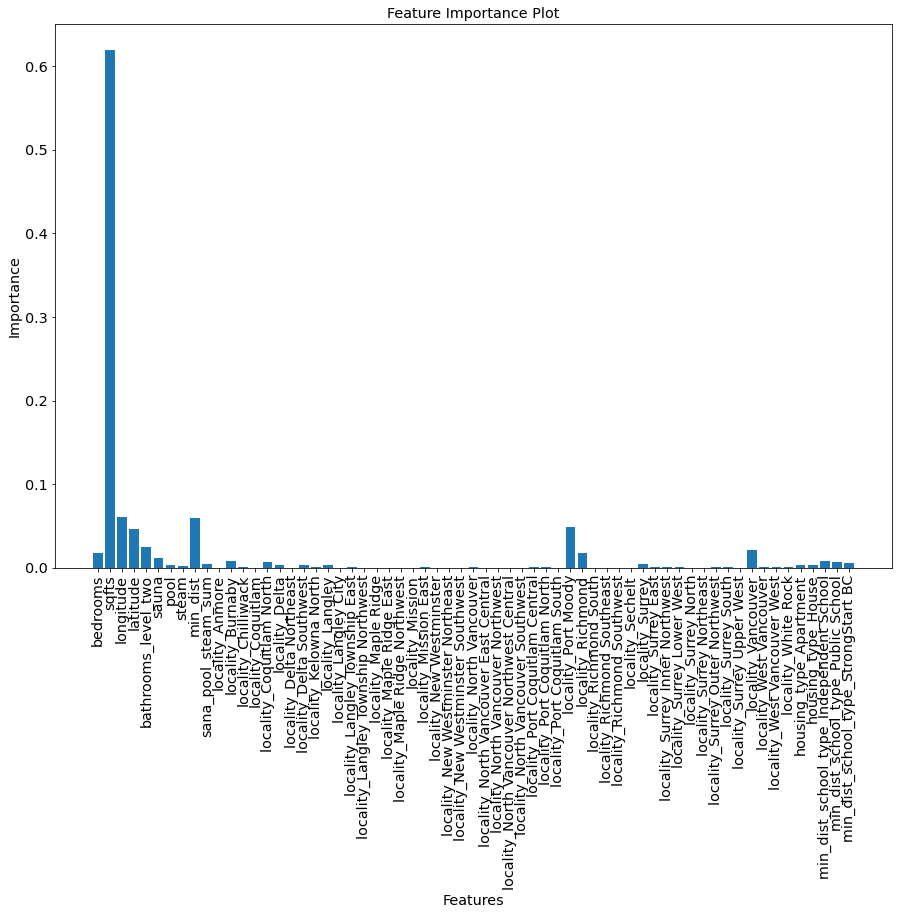

In [126]:
importances = regressor.feature_importances_

# Plot the feature importances
plt.figure(figsize=(15,10))
plt.bar(X_train.columns, importances)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance Plot")
plt.xticks(rotation=90)

plt.show()

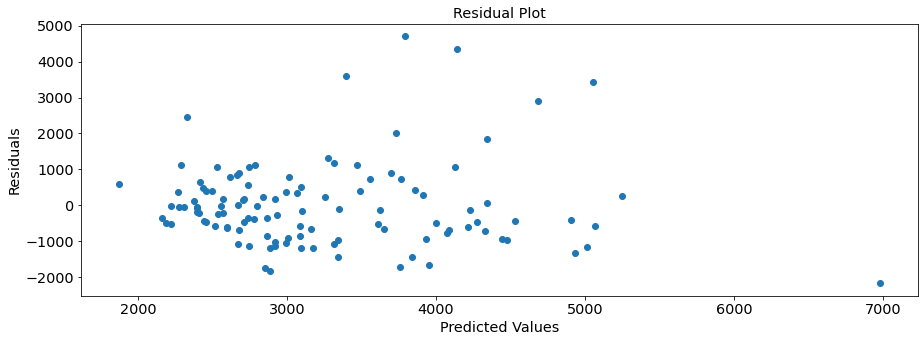

In [127]:
residuals = y_test - y_pred

# Plot the residuals
plt.scatter(y_pred, residuals)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

#### Encode

In [128]:
drop = ['name', 'streetAddress', 'country',  
                        'postal', 'region', 'links',
                      'min_dist_school_name']

#drop = ['name', 'streetAddress', 'country', 'locality', 
#                        'postal', 'region','housing_type', 'links',
#                        'min_dist_school_name', 'min_dist_school_type']
van_for_decision = van.drop(drop,1)

C:\Users\Daniel\AppData\Local\Temp\ipykernel_17656\3499190444.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  van_for_decision = van.drop(drop,1)


In [129]:
van_for_decision.columns

Index(['price', 'bedrooms', 'sqfts', 'longitude', 'latitude',
       'bathrooms_level_two', 'locality', 'housing_type', 'sauna', 'pool',
       'steam', 'min_dist', 'min_dist_school_type', 'sana_pool_steam_sum'],
      dtype='object')

In [130]:
van_for_decision_dropna = van_for_decision.dropna()

In [131]:
van_for_decision_dropna_encoded = pd.get_dummies(van_for_decision_dropna, columns=['locality', 'housing_type', 'min_dist_school_type'])

#### Decision Tree

In [132]:
# Converting boolean values to binary
van_for_decision_dropna_encoded[['sauna', 'pool', 'steam']] = van_for_decision_dropna_encoded[['sauna', 'pool', 'steam']].astype(int)

# Splitting the data into features and target variable
X = van_for_decision_dropna_encoded.drop('price', axis=1)
y = van_for_decision_dropna_encoded['price']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Initializing and fitting a random forest regressor
regressor = DecisionTreeRegressor()
regressor.fit(X_train, y_train)

# Predicting on the test data
y_pred = regressor.predict(X_test)

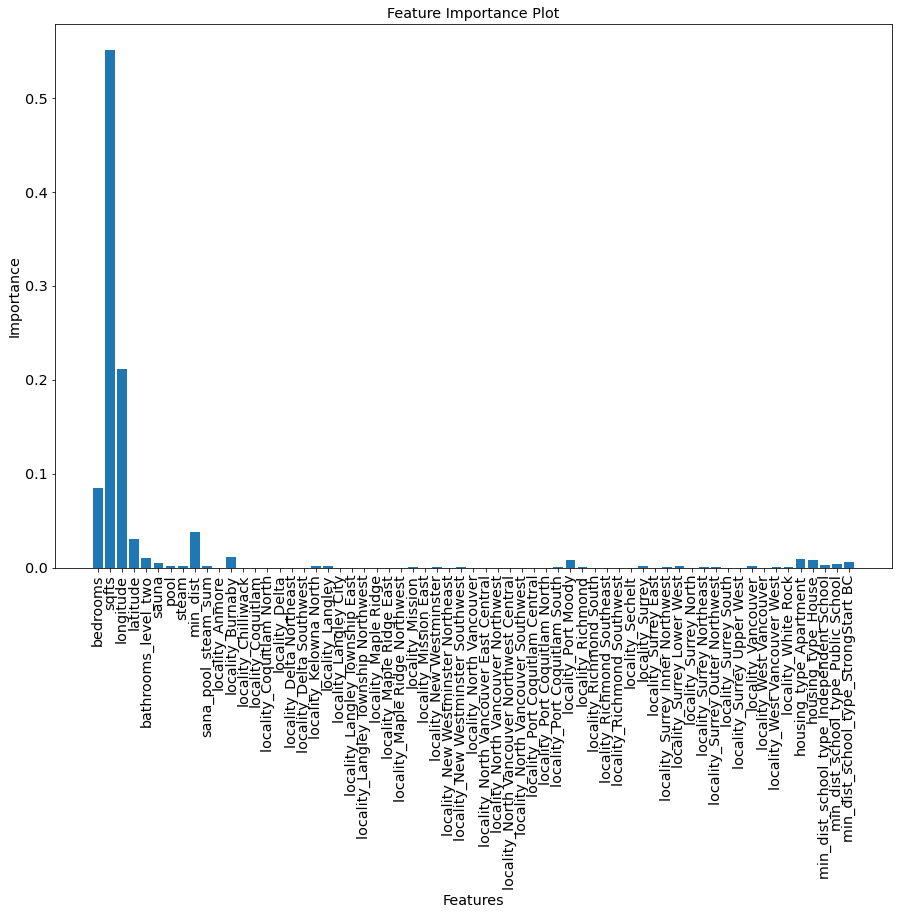

In [133]:
importances = regressor.feature_importances_

# Plot the feature importances
plt.figure(figsize=(15,10))
plt.bar(X_train.columns, importances)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance Plot")
plt.xticks(rotation=90)

plt.show()

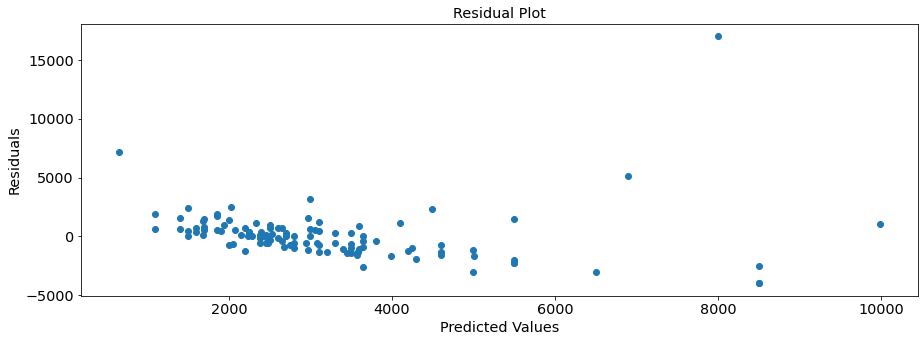

In [134]:
residuals = y_test - y_pred

# Plot the residuals
plt.scatter(y_pred, residuals)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

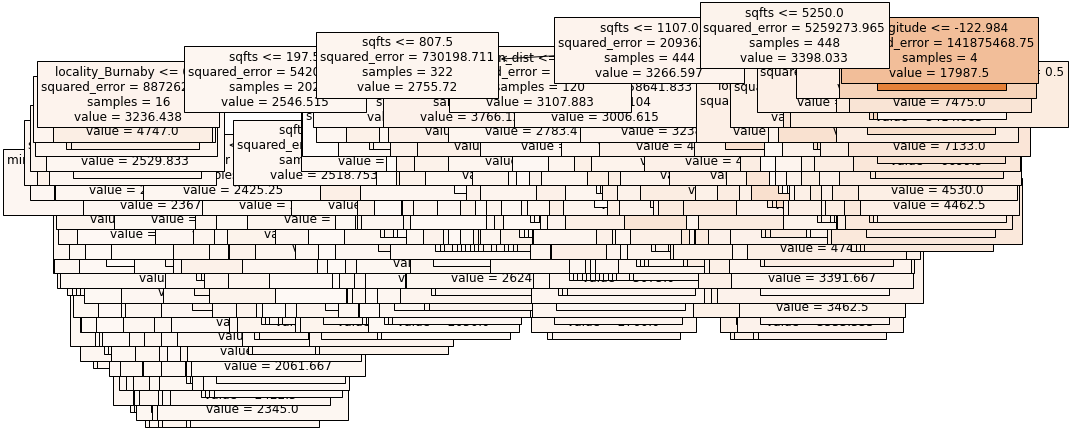

In [135]:
# Plot the decision tree
plt.figure(figsize=(15, 7))
plot_tree(regressor, filled=True, feature_names=X.columns, fontsize=12);

### XGBoost

In [136]:
drop = ['name', 'streetAddress', 'country',  
                        'postal', 'region', 'links',
                      'min_dist_school_name']

#drop = ['name', 'streetAddress', 'country', 'locality', 
#                        'postal', 'region','housing_type', 'links',
#                        'min_dist_school_name', 'min_dist_school_type']
van_XG = van.drop(drop,1)

C:\Users\Daniel\AppData\Local\Temp\ipykernel_17656\1820869273.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  van_XG = van.drop(drop,1)


In [137]:
van_XG = van_XG.dropna()

In [138]:
van_XG = pd.get_dummies(van_XG, columns=['locality', 'housing_type', 'min_dist_school_type'])

In [139]:
van_XG[['sauna', 'pool', 'steam']] = van_XG[['sauna', 'pool', 'steam']].astype(int)

In [140]:
van_XG

,price,bedrooms,sqfts,longitude,latitude,bathrooms_level_two,sauna,pool,steam,min_dist,...,locality_Surrey Upper West,locality_Vancouver,locality_West Vancouver,locality_West Vancouver West,locality_White Rock,housing_type_Apartment,housing_type_House,min_dist_school_type_Independent School,min_dist_school_type_Public School,min_dist_school_type_StrongStart BC
0,3000.0,1.0,784.0,-122.812341,49.023295,1.0,0,0,0,0.928307,...,0,0,0,0,1,1,0,1,0,0
1,3495.0,2.0,1000.0,-123.032026,49.312385,2.0,1,0,1,0.200205,...,0,0,0,0,0,1,0,0,1,0
2,5300.0,1.0,733.0,-123.078688,49.310206,1.0,1,0,1,0.909466,...,0,0,0,0,0,1,0,1,0,0
3,4500.0,3.0,1550.0,-123.097900,49.215600,4.0,0,0,0,0.195904,...,0,1,0,0,0,1,0,0,1,0
5,4295.0,2.0,1225.0,-123.129800,49.283300,2.0,0,0,0,0.047825,...,0,1,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,2800.0,2.0,850.0,-122.683336,49.123691,1.0,0,0,0,0.522564,...,0,0,0,0,0,1,0,1,0,0
797,4600.0,2.0,950.0,-123.120046,49.279562,2.0,0,0,0,0.391030,...,0,0,0,0,0,0,1,1,0,0
798,8500.0,2.0,1500.0,-122.860451,49.182578,1.0,0,0,0,0.557928,...,0,1,0,0,0,1,0,0,1,0
800,1900.0,3.0,614.0,-122.815261,49.211319,2.0,0,0,0,0.385491,...,0,1,0,0,0,1,0,1,0,0


In [141]:
# define the model
model = XGBClassifier()
# fit the model
X = van_XG.drop(['sauna'],1)
y  = van_XG['sauna']
model.fit(X, y)

NameError: name 'XGBClassifier' is not defined

In [ ]:
X.columns.to_list()

In [ ]:
model.feature_importances_.T

In [ ]:
feature_importance = pd.DataFrame(model.feature_importances_.T)


In [ ]:
feature_importance = feature_importance.T

In [ ]:
feature_importance.columns = X.columns

In [ ]:
feature_importance

In [ ]:
xgb_train, xgb_test = train_test_split(van_XG, test_size=0.3, random_state=0)

In [ ]:
len(xgb_train.index)

In [ ]:
xgb_train.info()